# **MSIN0097 Predictive Analytics Individual: Customer Segmentation**

## Table of Contents

- 0) Business Objective
- 1) Data Exploration
- 2) Data Cleaning
- 3) Feature Engineering
- 4) Preprocessing
- 5) Model Implementation
- 6) Model Evaluation
- 7) Conclusion
- 8) Limitation
- 9) Reference

In [1]:
# import packages
import datetime as dt
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

This Jupyter Notebook is uploaded to Github (https://github.com/kim-cui/MSIN0097-Individual-Assignment).

## **Business Objective**

The main objective of this individual task was to understand a company's target/non-target customers. Given a dataset of customer purchase history, we wanted to extract RFM (recency, frequency and monetary) information of customers and segment them based on such information. For marketing and CRM purposes, we need to segment the customers into 3 types - high-value (loyal customers, who always purchase products), high-potential (customers who are not purchasing too much but could become high-value), and low-value (customers who rarely purchase products). The goal is to send marketing campigns to high-potential customers and transform them into high-value customers.

## **Data Exploration**

The dataset is found on Data World (https://data.world/iabhishek/customersegmentation/workspace/file?filename=customer_segmentation.csv), it consists of 8 features - invoice no, stockcode, description, quantity, invoice date, date time, unit price, customer ID and country.


In [2]:
# import data
df_origin = pd.read_csv('customer_segmentation.csv')
df = df_origin.copy()
print(df.dtypes)
df.head()

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object


InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom

### Elementary Data Cleaning

In [3]:
# check missing values
missing_value_per = df.isnull().sum() / df.shape[0] * 100
print(missing_value_per)

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64


Around 25% of customerID are missing. CustomerID is an important feature as we cannot segment unidentified customers. We choose to drop all the missing customerID. To get a cleaner dataset, we will drop the missing 2.6% Description as well.

In [4]:
# drop all missing value and duplicates
df = df.dropna()
df = df.drop_duplicates()

# format customer ID and time
df['CustomerID'] = df['CustomerID'].astype('int')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'],infer_datetime_format=True)
# reset the index
df.reset_index()

index InvoiceNo StockCode                          Description  \
0            0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER   
1            1    536365     71053                  WHITE METAL LANTERN   
2            2    536365    84406B       CREAM CUPID HEARTS COAT HANGER   
3            3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE   
4            4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.   
...        ...       ...       ...                                  ...   
401599  541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS   
401600  541905    581587     22899         CHILDREN'S APRON DOLLY GIRL    
401601  541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL    
401602  541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE   
401603  541908    581587     22138        BAKING SET 9 PIECE RETROSPOT    

        Quantity         InvoiceDate  UnitPrice  CustomerID         Country  
0              6 2010-12-01 08:26:00       2.55       17850  United Kingdom  
1              6 2010-12-01 08:26:00       3.39       17850  United Kingdom  
2              8 2010-12-01 08:26:00       2.75       17850  United Kingdom  
3              6 2010-12-01 08:26:00       3.39       17850  United Kingdom  
4              6 2010-12-01 08:26:00       3.39       17850  United Kingdom  
...          ...                 ...        ...         ...             ...  
401599        12 2011-12-09 12:50:00       0.85       12680          France  
401600         6 2011-12-09 12:50:00       2.10       12680          France  
401601         4 2011-12-09 12:50:00       4.15       12680          France  
401602         4 2011-12-09 12:50:00       4.15       12680          France  
401603         3 2011-12-09 12:50:00       4.95       12680          France  

[401604 rows x 9 columns]

### Data Visualisation

#### Top 10 Most Bought Products

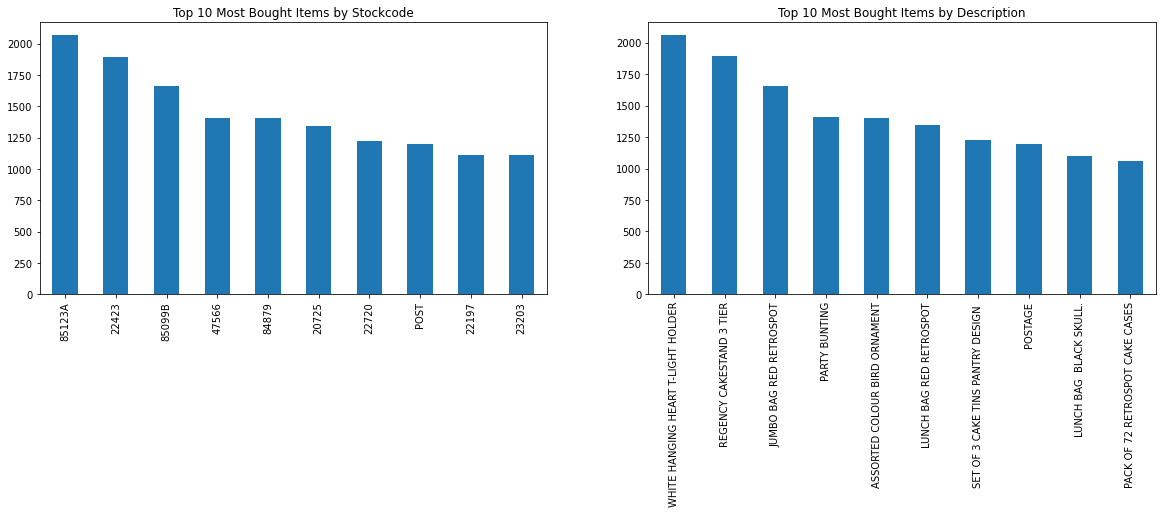

In [5]:
# plot the top 10 most bought items
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
df['StockCode'].value_counts().head(10).plot.bar()
plt.title('Top 10 Most Bought Items by Stockcode')
plt.xticks(rotation = 90 )


plt.subplot(1,2,2)
df['Description'].value_counts().head(10).plot.bar()
plt.title('Top 10 Most Bought Items by Description')
plt.xticks(rotation = 90 )
plt.show()

Notice the 8th most bought item is called 'POST' / 'POSTAGE'. This indicates some of the stock codes may not represent a product. This needs further investigation.

#### Transactions in Different Countries

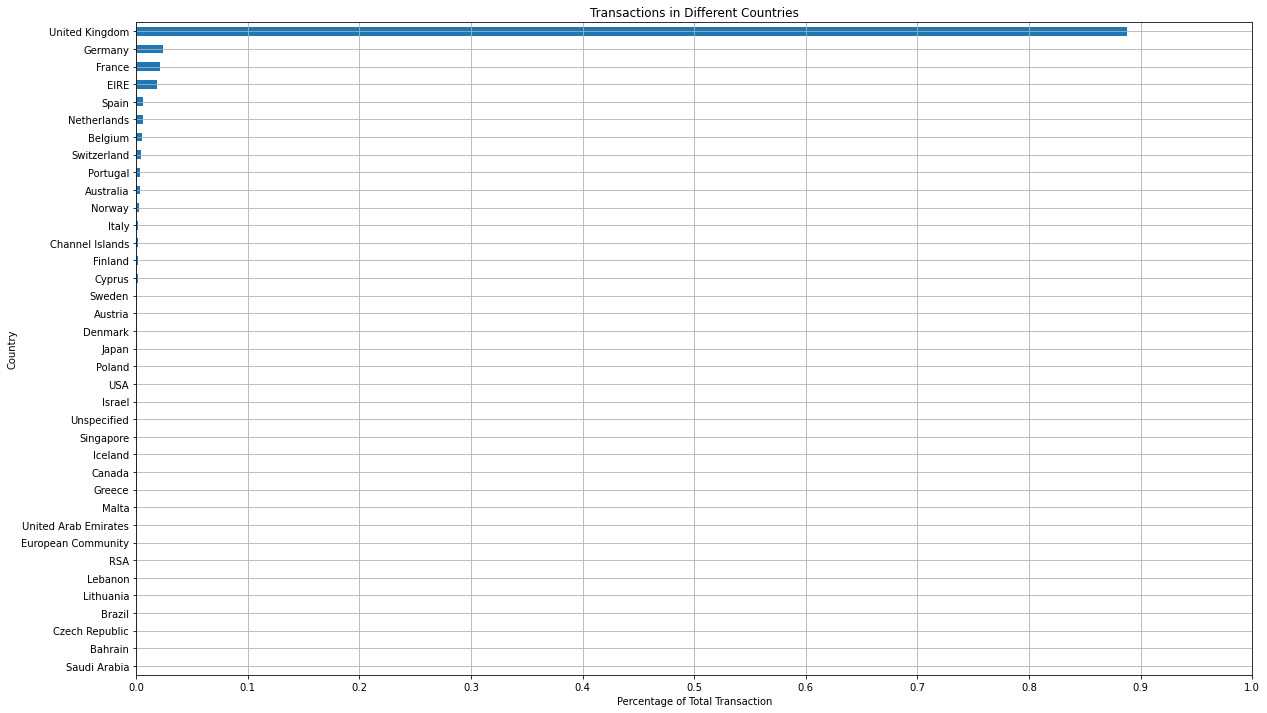

In [6]:
country_invoice = df.groupby('Country')['InvoiceNo'].count().sort_values() / len(df)
plt.subplots(figsize=(20,12))
country_invoice.plot(kind='barh')
plt.xlabel('Percentage of Total Transaction')
plt.ylabel('Country')
plt.title('Transactions in Different Countries')
plt.xticks(np.arange(0,1.05,0.1))
plt.grid()
plt.show()

Most of the customers are based in the UK, to make sure the dataset does not have any systematical error (e.g. forget to input customer data from other countries), we will drop non-UK customers later.

#### Boxplot on Quantitative Variables

[]

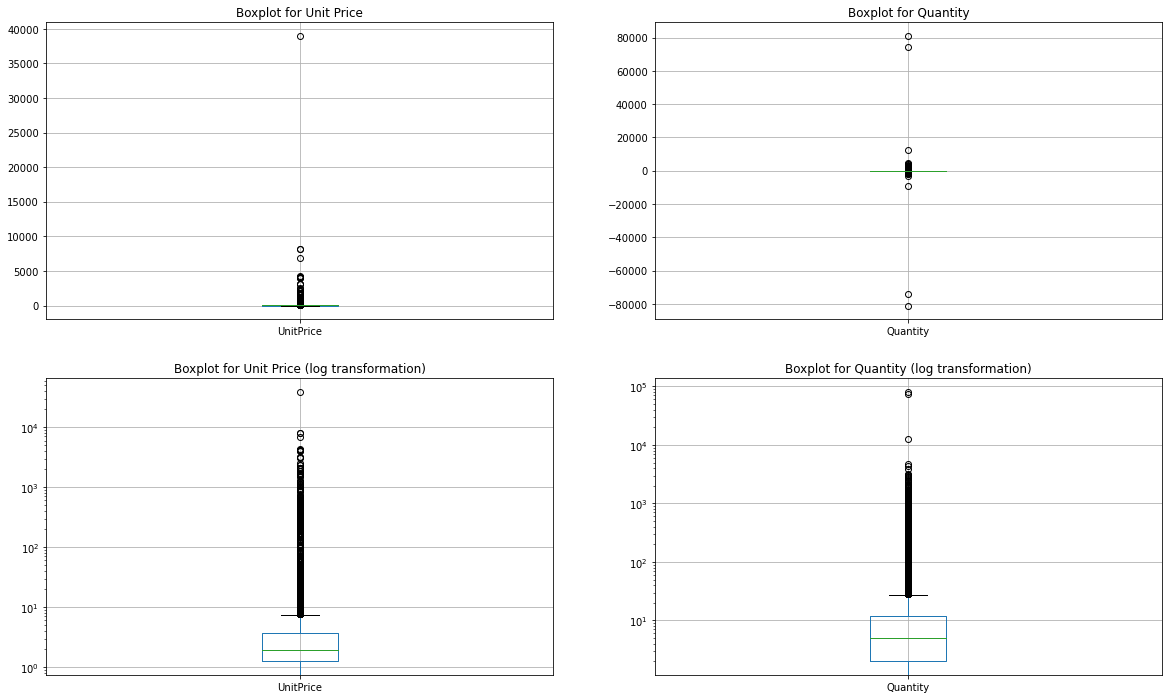

In [7]:
# boxplot on unitprice and quantity
plt.figure(figsize=(20,12))
plt.subplot(2,2,1)
df.boxplot(column=['UnitPrice'])
plt.title('Boxplot for Unit Price')  

plt.subplot(2,2,2)
df.boxplot(column=['Quantity'])  
plt.title('Boxplot for Quantity')
plt.plot()

plt.subplot(2,2,3)
plt.yscale("log") # apply log to y-axis
df.boxplot(column=['UnitPrice'])  
plt.title('Boxplot for Unit Price (log transformation)')
plt.plot()

plt.subplot(2,2,4)
plt.yscale("log") # apply log to y-axis
df.boxplot(column=['Quantity'])  
plt.title('Boxplot for Quantity (log transformation)')
plt.plot()


Unit price and quantity have extreme outliers, this indicates outlier removal is necessary. Also looking at the boxplot for quantity, how can we have negative quantities? This requires further investigation.

#### Monthly and Daily Sales

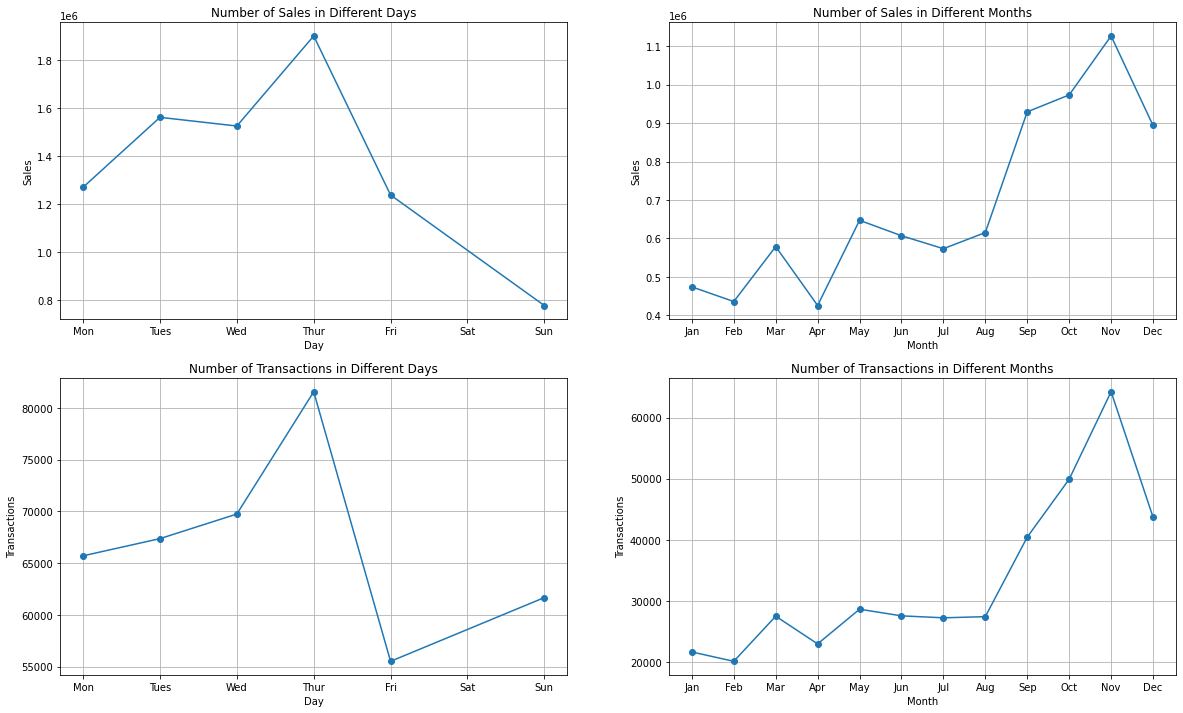

In [8]:
# analysing monthly and daily sales and transactions
# add columns for month and day
df['Month'] = df['InvoiceDate'].dt.month
df['Day'] = df['InvoiceDate'].dt.dayofweek + 1 # need to add 1 because 'dayofweek' starts from 0 to 6
df['TotalPrice'] = df['Quantity'] * df['UnitPrice'] # add a total value of purchase
weekdays_num = [1,2,3,4,5,6,7]
weekdays = ['Mon', 'Tues', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
months_num = [1,2,3,4,5,6,7,8,9,10,11,12]
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# plot the graphs
# revenue by day
plt.subplots(figsize=(20,12))
plt.subplot(2,2,1)
df.groupby('Day').TotalPrice.sum().plot( marker='o')
plt.xlabel('Day')
plt.ylabel('Sales')
plt.title('Number of Sales in Different Days')
plt.xticks(weekdays_num, weekdays) 
plt.grid()

# revenue by month
plt.subplot(2,2,2)
df.groupby('Month').TotalPrice.sum().plot( marker='o')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Number of Sales in Different Months')
plt.xticks(months_num, months)
plt.grid()

# number of orders by day
plt.subplot(2,2,3)
df.groupby('Day').InvoiceNo.count().plot( marker='o')
plt.xlabel('Day')
plt.ylabel('Transactions')
plt.title('Number of Transactions in Different Days')
plt.xticks(weekdays_num, weekdays) 
plt.grid()

#number of orders by montho
plt.subplot(2,2,4)
df.groupby('Month').InvoiceNo.count().plot( marker='o')
plt.xlabel('Month')
plt.ylabel('Transactions')
plt.title('Number of Transactions in Different Months')
plt.xticks(months_num, months) 
plt.grid()


plt.show()

Here are some interesting insights from the graphs.

- There are no sales/transactions on Saturdays. Since there is no specific reason why customers are not shopping online on Saturdays, this indicates the e-commerce shop may be closed on Saturdays. 

- The number of sales and transactions peaks in November, which can be explained by the increase in purchases during the holiday season.

- Friday sales were much higher than Sunday sales, but the number of transactions on Sunday was higher than the number of transactions on Friday. This is unusual and suggests that some transactions did not generate revenue. This requires further investigation.


## **Data Cleaning**

Based on EDA, we need to investigate the following.

1. Strange values in stockcode, e.g. POST.

2. Need to drop all countries other than UK to avoid systematical bias.

3. Need to solve the problem of extreme outliers.

4. Negative values in quantity.

5. Some transactions are not generating revenues.

### Strange Stockcode

In [9]:
df[df['StockCode'] == 'POST']

InvoiceNo StockCode Description  Quantity         InvoiceDate  \
45        536370      POST     POSTAGE         3 2010-12-01 08:45:00   
386       536403      POST     POSTAGE         1 2010-12-01 11:27:00   
1123      536527      POST     POSTAGE         1 2010-12-01 13:04:00   
5073      536840      POST     POSTAGE         1 2010-12-02 18:27:00   
5258      536852      POST     POSTAGE         1 2010-12-03 09:51:00   
...          ...       ...         ...       ...                 ...   
541198    581493      POST     POSTAGE         1 2011-12-09 10:10:00   
541216    581494      POST     POSTAGE         2 2011-12-09 10:13:00   
541730    581570      POST     POSTAGE         1 2011-12-09 11:59:00   
541767    581574      POST     POSTAGE         2 2011-12-09 12:09:00   
541768    581578      POST     POSTAGE         3 2011-12-09 12:16:00   

        UnitPrice  CustomerID      Country  Month  Day  TotalPrice  
45           18.0       12583       France     12    3        54.0  
386          15.0       12791  Netherlands     12    3        15.0  
1123         18.0       12662      Germany     12    3        18.0  
5073         18.0       12738      Germany     12    4        18.0  
5258         18.0       12686       France     12    5        18.0  
...           ...         ...          ...    ...  ...         ...  
541198       15.0       12423      Belgium     12    5        15.0  
541216       18.0       12518      Germany     12    5        36.0  
541730       18.0       12662      Germany     12    5        18.0  
541767       18.0       12526      Germany     12    5        36.0  
541768       18.0       12713      Germany     12    5        54.0  

[1196 rows x 11 columns]

It seems that postage is the cost of shipping. As long as this cost is paid by the customer (quantity and unit price are both positive), we don't need to pay attention to strange stock codes. We will treat these rows as part of customers' spending and keep them. Now let's have a look of what other non-numerical stockcodes we have.

In [10]:
# check stockcode contains letters
strange_stockcode = df[df['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
strange_stockcode

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK'],
      dtype=object)

In [11]:
# Start by checking Stockcode 'D'
df[df['StockCode'] == 'D']

InvoiceNo StockCode Description  Quantity         InvoiceDate  \
141      C536379         D    Discount        -1 2010-12-01 09:41:00   
9038     C537164         D    Discount        -1 2010-12-05 13:21:00   
14498    C537597         D    Discount        -1 2010-12-07 12:34:00   
19392    C537857         D    Discount        -1 2010-12-08 16:00:00   
31134    C538897         D    Discount        -1 2010-12-15 09:14:00   
...          ...       ...         ...       ...                 ...   
479868   C577227         D    Discount        -1 2011-11-18 12:06:00   
479869   C577227         D    Discount        -1 2011-11-18 12:06:00   
493613   C578239         D    Discount        -1 2011-11-23 12:29:00   
516221   C579884         D    Discount        -1 2011-11-30 17:34:00   
516455   C579908         D    Discount        -1 2011-12-01 08:49:00   

        UnitPrice  CustomerID         Country  Month  Day  TotalPrice  
141         27.50       14527  United Kingdom     12    3      -27.50  
9038        29.29       14527  United Kingdom     12    7      -29.29  
14498      281.00       15498  United Kingdom     12    2     -281.00  
19392      267.12       17340  United Kingdom     12    3     -267.12  
31134        5.76       16422  United Kingdom     12    3       -5.76  
...           ...         ...             ...    ...  ...         ...  
479868      19.82       14527  United Kingdom     11    5      -19.82  
479869      16.76       14527  United Kingdom     11    5      -16.76  
493613      26.33       14912           Italy     11    3      -26.33  
516221      20.53       14527  United Kingdom     11    3      -20.53  
516455      28.68       14527  United Kingdom     12    4      -28.68  

[77 rows x 11 columns]

Stockcode 'D' represents discount. Here are few things noticible.

- InvoiceNo starting with C.

- Quantity is negative.

A negative number seems to indicate that the company is paying for an order, which could be related to InvoiceNo starting with C. We need to get rid of all these rows as we only want a dataset that represents only the customer's spending, not the company's, or both.

In [12]:
# check all orders starting with 'C'
df_c = df[df['InvoiceNo'].apply(lambda l: l[0]=="C")]
df_c

InvoiceNo StockCode                       Description  Quantity  \
141      C536379         D                          Discount        -1   
154      C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235      C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236      C536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237      C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   
...          ...       ...                               ...       ...   
540449   C581490     23144   ZINC T-LIGHT HOLDER STARS SMALL       -11   
541541   C581499         M                            Manual        -1   
541715   C581568     21258        VICTORIAN SEWING BOX LARGE        -5   
541716   C581569     84978  HANGING HEART JAR T-LIGHT HOLDER        -1   
541717   C581569     20979     36 PENCILS TUBE RED RETROSPOT        -5   

               InvoiceDate  UnitPrice  CustomerID         Country  Month  Day  \
141    2010-12-01 09:41:00      27.50       14527  United Kingdom     12    3   
154    2010-12-01 09:49:00       4.65       15311  United Kingdom     12    3   
235    2010-12-01 10:24:00       1.65       17548  United Kingdom     12    3   
236    2010-12-01 10:24:00       0.29       17548  United Kingdom     12    3   
237    2010-12-01 10:24:00       0.29       17548  United Kingdom     12    3   
...                    ...        ...         ...             ...    ...  ...   
540449 2011-12-09 09:57:00       0.83       14397  United Kingdom     12    5   
541541 2011-12-09 10:28:00     224.69       15498  United Kingdom     12    5   
541715 2011-12-09 11:57:00      10.95       15311  United Kingdom     12    5   
541716 2011-12-09 11:58:00       1.25       17315  United Kingdom     12    5   
541717 2011-12-09 11:58:00       1.25       17315  United Kingdom     12    5   

        TotalPrice  
141         -27.50  
154          -4.65  
235         -19.80  
236          -6.96  
237          -6.96  
...            ...  
540449       -9.13  
541541     -224.69  
541715      -54.75  
541716       -1.25  
541717       -6.25  

[8872 rows x 11 columns]

In [13]:
print('Percentage of "C" orders in the current dataset:', len(df[df['InvoiceNo'].apply(lambda l: l[0]=="C")])/len(df) * 100)

# is there any 'C' orders that has postive quantity?
print('The number of "C" orders with positive quantity:', df_c[df_c['Quantity'] > 0]['InvoiceNo'].count())

Percentage of "C" orders in the current dataset: 2.209141343213713
The number of "C" orders with positive quantity: 0


All the orders starting with 'C' have negative quantity. Since these orders are only 2.2% of the dataset, we will drop all of them.

In [14]:
# drop all "C" orders
df = df.drop(df[df['InvoiceNo'].apply(lambda l: l[0]=="C")].index)

# check if we still have negative quantity entries
print('The number of entries with negative quantity now:',df[df['Quantity'] <0]['InvoiceNo'].count())

The number of entries with negative quantity now: 0


After dropping all the "C" orders, there is no entry with a negative quantity. This indicates that orders with anegative quantity are recorded with 'C' at the beginning of their invoice no.

We have now solved problems 1,4 and 5, the reason why some orders do not generate revenue is because their quantity is negative (so the revenue is negative). We have got rid of all of them and the dataset now represents only the spending behavior of customers. We now drop all countries outside of UK to solve problem 2.

In [15]:
# drop all non-uk countries
df = df.drop(df[df['Country'] != 'United Kingdom'].index);

# reset the index
df.reset_index();

The problem of outliers (problem 4) will be solved in the next section - Feature Engineering.

## **Feature Engineering**

We will segment customers based on their RFM data:

- Recency (when is a customer's last purchase)

- Frequency (how many times has a customer purchased)

- Monetary (how much money has a customer spent in total)

Now let's construct a dataframe of RFM.

### RFM

In [16]:
# construct a new data framework of RFM , we will use this dataframe for customer segmentation

# construct a new dataframe with RFM
# Monetary
customer = df.groupby('CustomerID')[['TotalPrice']].sum()
customer.rename(columns={'TotalPrice':'Monetary'},inplace=True)
# Recency
max_date = max(df['InvoiceDate'])
df['diff'] = max_date - df['InvoiceDate']
customer['Recency'] = df.groupby('CustomerID')['diff'].min().dt.days
# Frequency
customer['Frequency'] = df.groupby('CustomerID')['InvoiceNo'].count()

# reset the index
customer = customer.reset_index()
#customer = customer.drop(columns = ['CustomerID'])
customer

CustomerID  Monetary  Recency  Frequency
0          12346  77183.60      325          1
1          12747   4196.01        1        103
2          12748  33053.19        0       4413
3          12749   4090.88        3        199
4          12820    942.34        2         59
...          ...       ...      ...        ...
3916       18280    180.60      277         10
3917       18281     80.82      180          7
3918       18282    178.05        7         12
3919       18283   2045.53        3        721
3920       18287   1837.28       42         70

[3921 rows x 4 columns]

           Monetary   Recency  Frequency
Monetary    1.00000 -0.128960   0.329670
Recency    -0.12896  1.000000  -0.212664
Frequency   0.32967 -0.212664   1.000000


<AxesSubplot:>

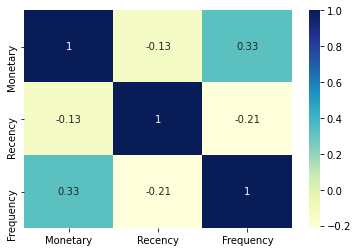

In [17]:
print(customer.drop(columns= ['CustomerID']).corr())
sns.heatmap(customer.drop(columns= ['CustomerID']).corr(),cmap="YlGnBu", annot=True) #cmap change

We see some strong correlations, this is a good sign for clustering.

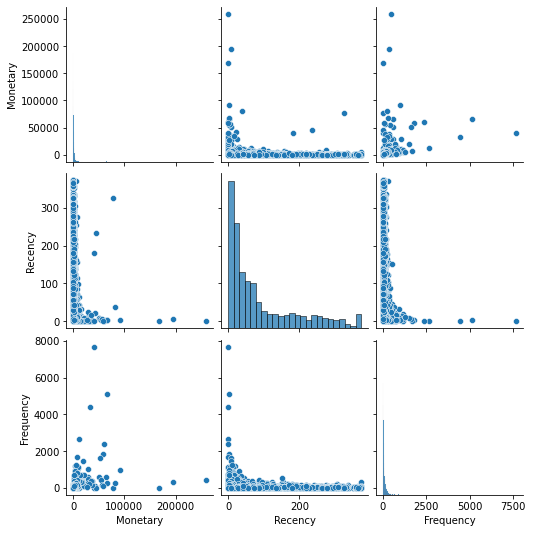

In [18]:
sns.pairplot(data=customer.drop(columns= ['CustomerID']))

The scales of features are different. We also notice the outlier effect is very strong (this is due to the outliers in quantity and unit price mentioned in question 4 earlier). We need to deal with both situations becasuse some clustering models (e.g. K-means) are very sensitive with scale and outliers.

### Outliers Removal

<ipython-input-19-071b434bcecb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer.iloc[:,j][customer.iloc[:,j] > customer.iloc[:,j].quantile(0.95)] = customer.iloc[:,j].quantile(0.95)
<ipython-input-19-071b434bcecb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer.iloc[:,j][customer.iloc[:,j] < customer.iloc[:,j].quantile(0.05)] = customer.iloc[:,j].quantile(0.05)
<ipython-input-19-071b434bcecb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

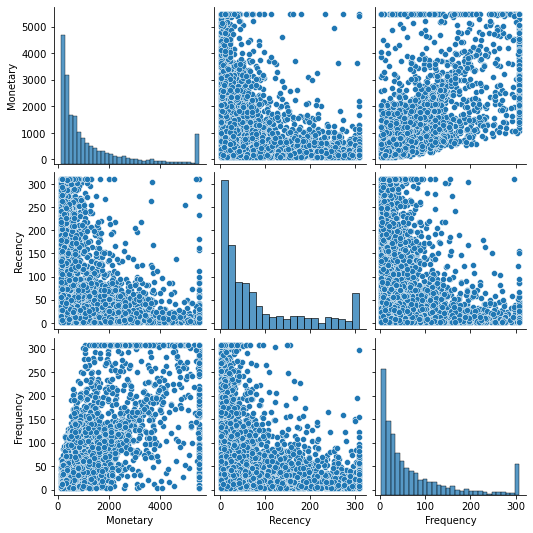

In [19]:
# get rid of the outlier effect by replacing the top and low 5% quantiles of each feature
for j in range(1,4):
    customer.iloc[:,j][customer.iloc[:,j] > customer.iloc[:,j].quantile(0.95)] = customer.iloc[:,j].quantile(0.95)
    customer.iloc[:,j][customer.iloc[:,j] < customer.iloc[:,j].quantile(0.05)] = customer.iloc[:,j].quantile(0.05)

sns.pairplot(data=customer.drop(columns= ['CustomerID']))

Outliers effect is reduced. We now need to scale the features. We will do this in the next section - Preprocessing.

## **Preprocessing**

In this section, we will include feature scaling and dimension reduction.

### Feature Scaling

We will consider two types of scaler/normalisation - MinMax and Z-score. 

In [20]:
# minmax scaler
scaler_1 = MinMaxScaler()
# fit and transform the data
customer_minmax = pd.DataFrame(scaler_1.fit_transform(customer.drop(columns=['CustomerID'])), 
                               columns=['Monetary','Recency', 'Frequency'])


# z-score normalisation
customer_z = customer.drop(columns=['CustomerID']).copy()
customer_z = (customer_z-customer_z.mean())/(customer_z.std())

### Dimension Reduction

For better clustering results, we now reduce the dimension to 2 using PCA.

In [21]:
pca = PCA(n_components=2, random_state = 42)
# pca for minmax data
df_pca_minmax = pd.DataFrame(pca.fit_transform(customer_minmax), columns = ['PCA_1', 'PCA_2'])
# pca for z-score data
df_pca_z = pd.DataFrame(pca.fit_transform(customer_z), columns = ['PCA_1', 'PCA_2'])

## **Model Implementation**

In this section, we will implement 4 different clustering models on the 2 normalised datasets. The clustering method we consider are K-means, DBSCAN, agglomerative hierarchical clustering, and Gaussian Mixture. Thus, there will be 8 models in total.

### **K-means with MinMax Normalisation**

Based on our business objective, the number of cluster (k number) is 3.

In [22]:
# set k number and run the model
k=3
kmeans = KMeans(n_clusters=k, max_iter=50, random_state=42)
y_pred = kmeans.fit_predict(df_pca_minmax)

# add cluster labels to the dataframe
customer_model1 = customer.copy()
customer_model1['cluster_id'] = kmeans.labels_
df_pca_minmax['cluster_id'] = kmeans.labels_

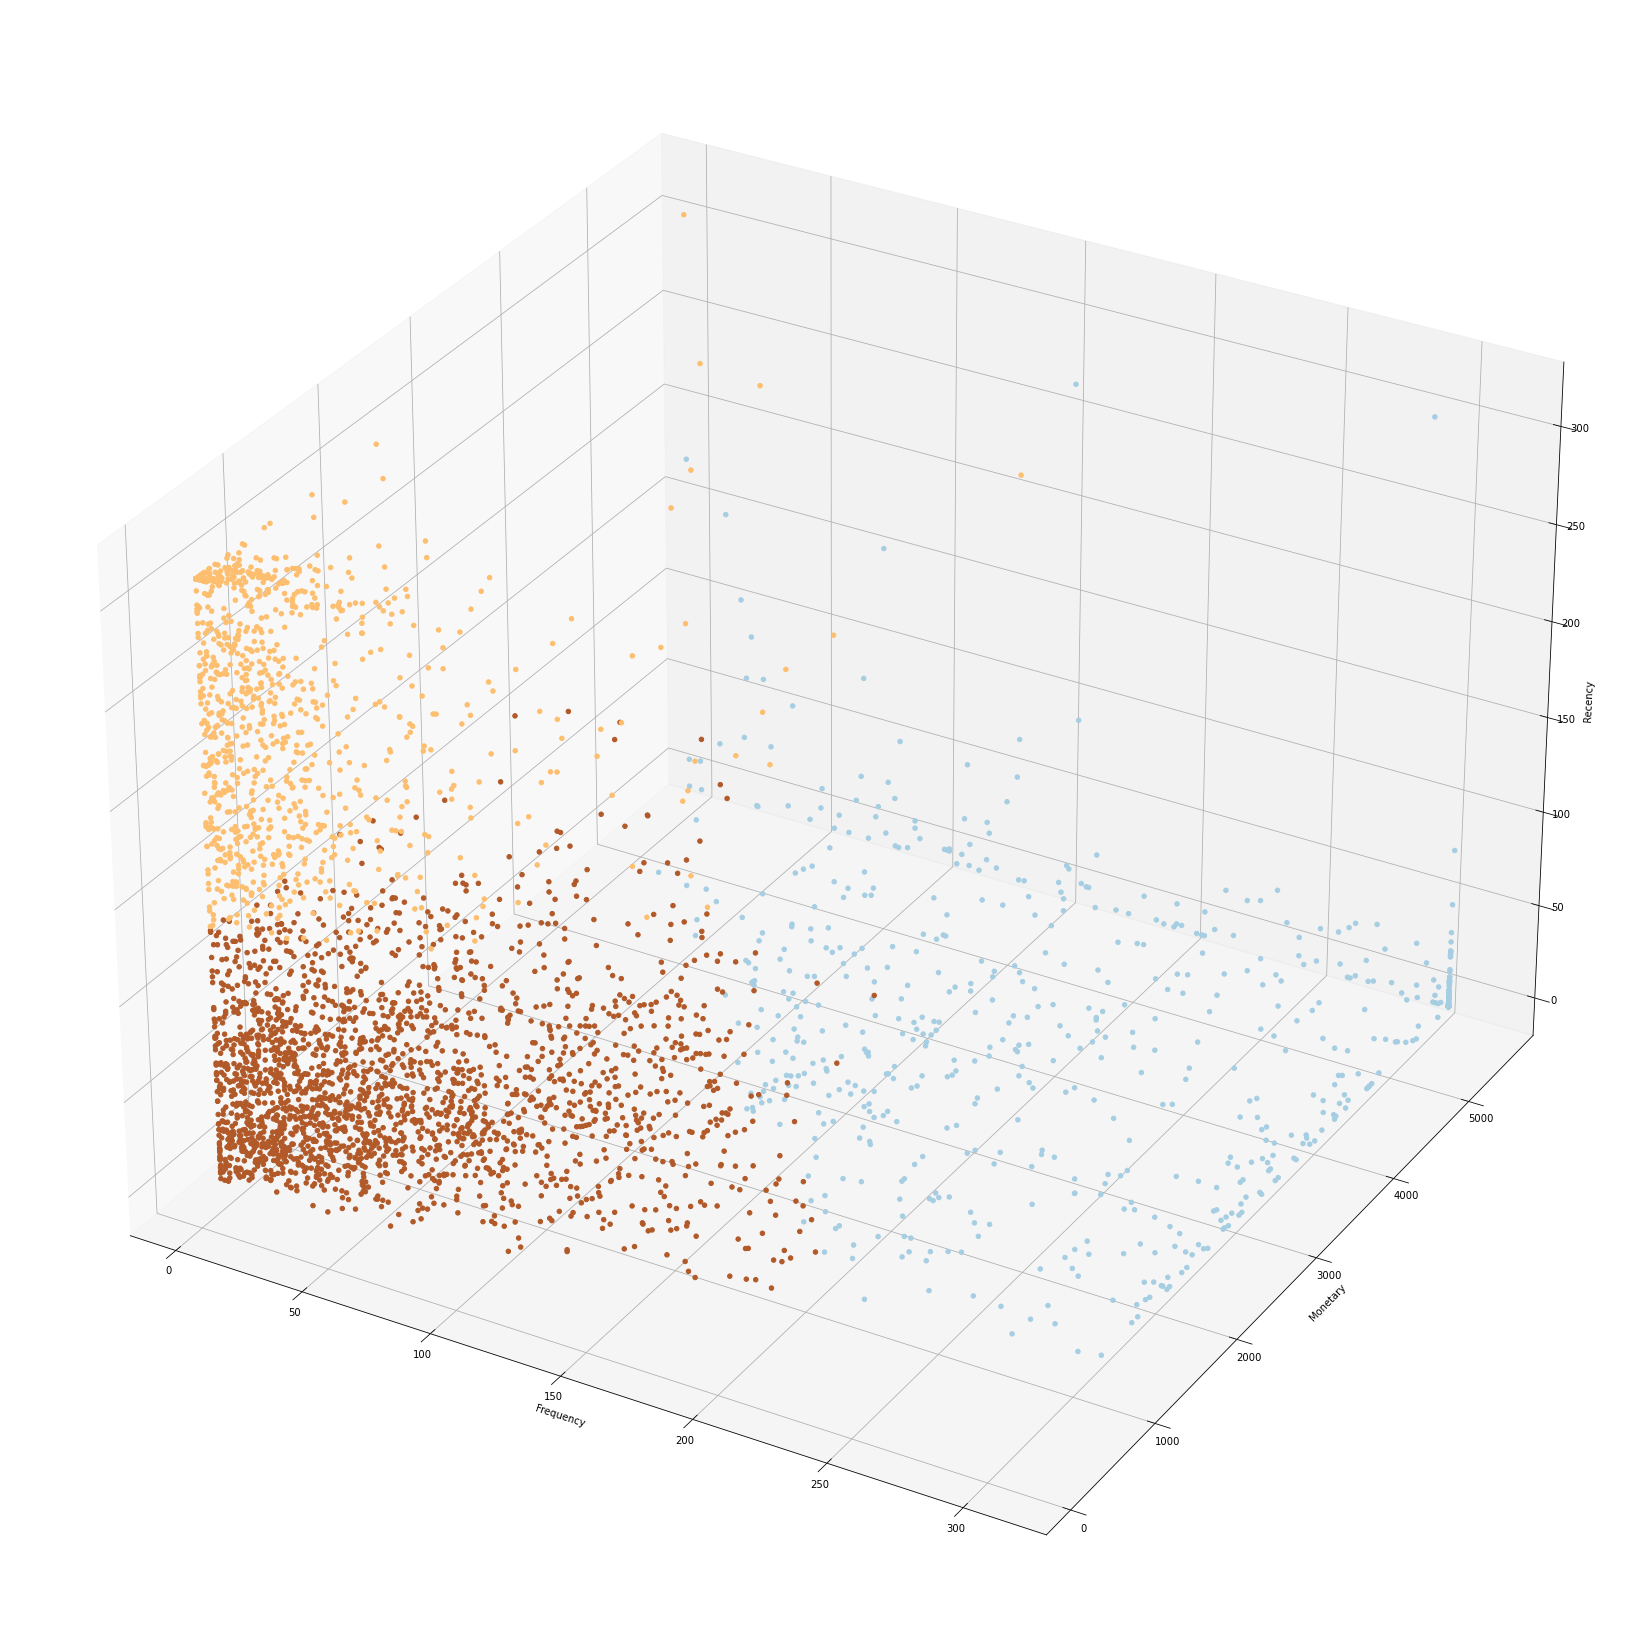

In [23]:
# plot a 3d graph
fig = plt.figure(figsize=[30,30])
ax = fig.add_subplot( projection = '3d')
# set x,y,z axis
x = customer_model1['Frequency']
y = customer_model1['Monetary']
z = customer_model1['Recency']
# set color map
cmap = ListedColormap(sns.color_palette("Paired"))
# set axis name
ax.set_xlabel("Frequency")
ax.set_ylabel("Monetary")
ax.set_zlabel("Recency")   
# 3d scatter plot
ax.scatter(x, y, z, c = customer_model1['cluster_id'], cmap = cmap , alpha=1)
plt.show()

#### Evaluation on $k$ 

Now let's evaluate how good the clustering is when $k=3$. We will consider the SSD socre and silhouette score.

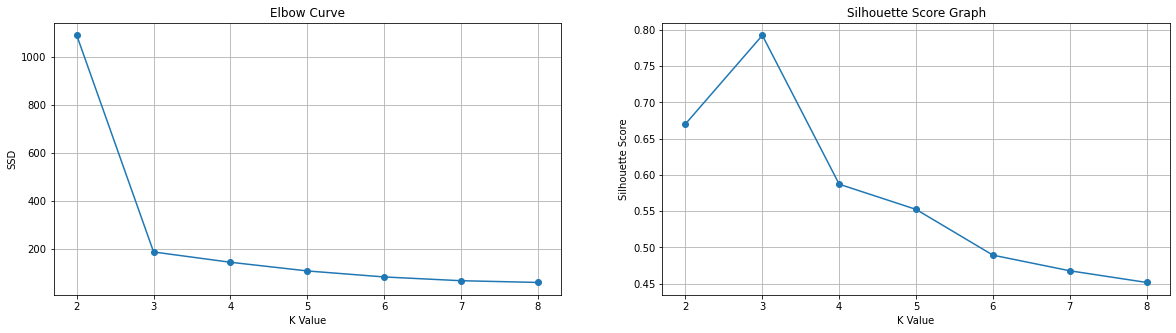

In [24]:
# compute ssd score
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7,8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50, random_state=42)
    kmeans.fit(df_pca_minmax)
    ssd.append(kmeans.inertia_)

# compute silhouette score
sil_scores = []
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50, random_state=42)
    kmeans.fit(df_pca_minmax)
    cluster_labels = kmeans.labels_
    sil_avg = silhouette_score(df_pca_minmax, cluster_labels)
    sil_scores.append(sil_avg)

# construct the plot    
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(range_n_clusters,ssd, marker = 'o')
plt.xlabel('K Value')
plt.ylabel('SSD')
plt.title('Elbow Curve')
plt.grid()

plt.subplot(1,2,2)
plt.plot(range_n_clusters,sil_scores, marker = 'o')
plt.xlabel('K Value')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Graph')
plt.grid()
plt.show()

We see the best number of $k$ based on SSD and Silhouette scores is 3. This is great, our business objective corresponds with the best hyperparameter.

### **K-means with Z-score Normalisation**

Again, set $k=3$.

In [25]:
# set k number and run the model
k=3
kmeans = KMeans(n_clusters=k, max_iter=50, random_state=42)
y_pred = kmeans.fit_predict(df_pca_z)

# add cluster labels to dataframe
customer_model2 = customer.copy()
customer_model2['cluster_id'] = kmeans.labels_

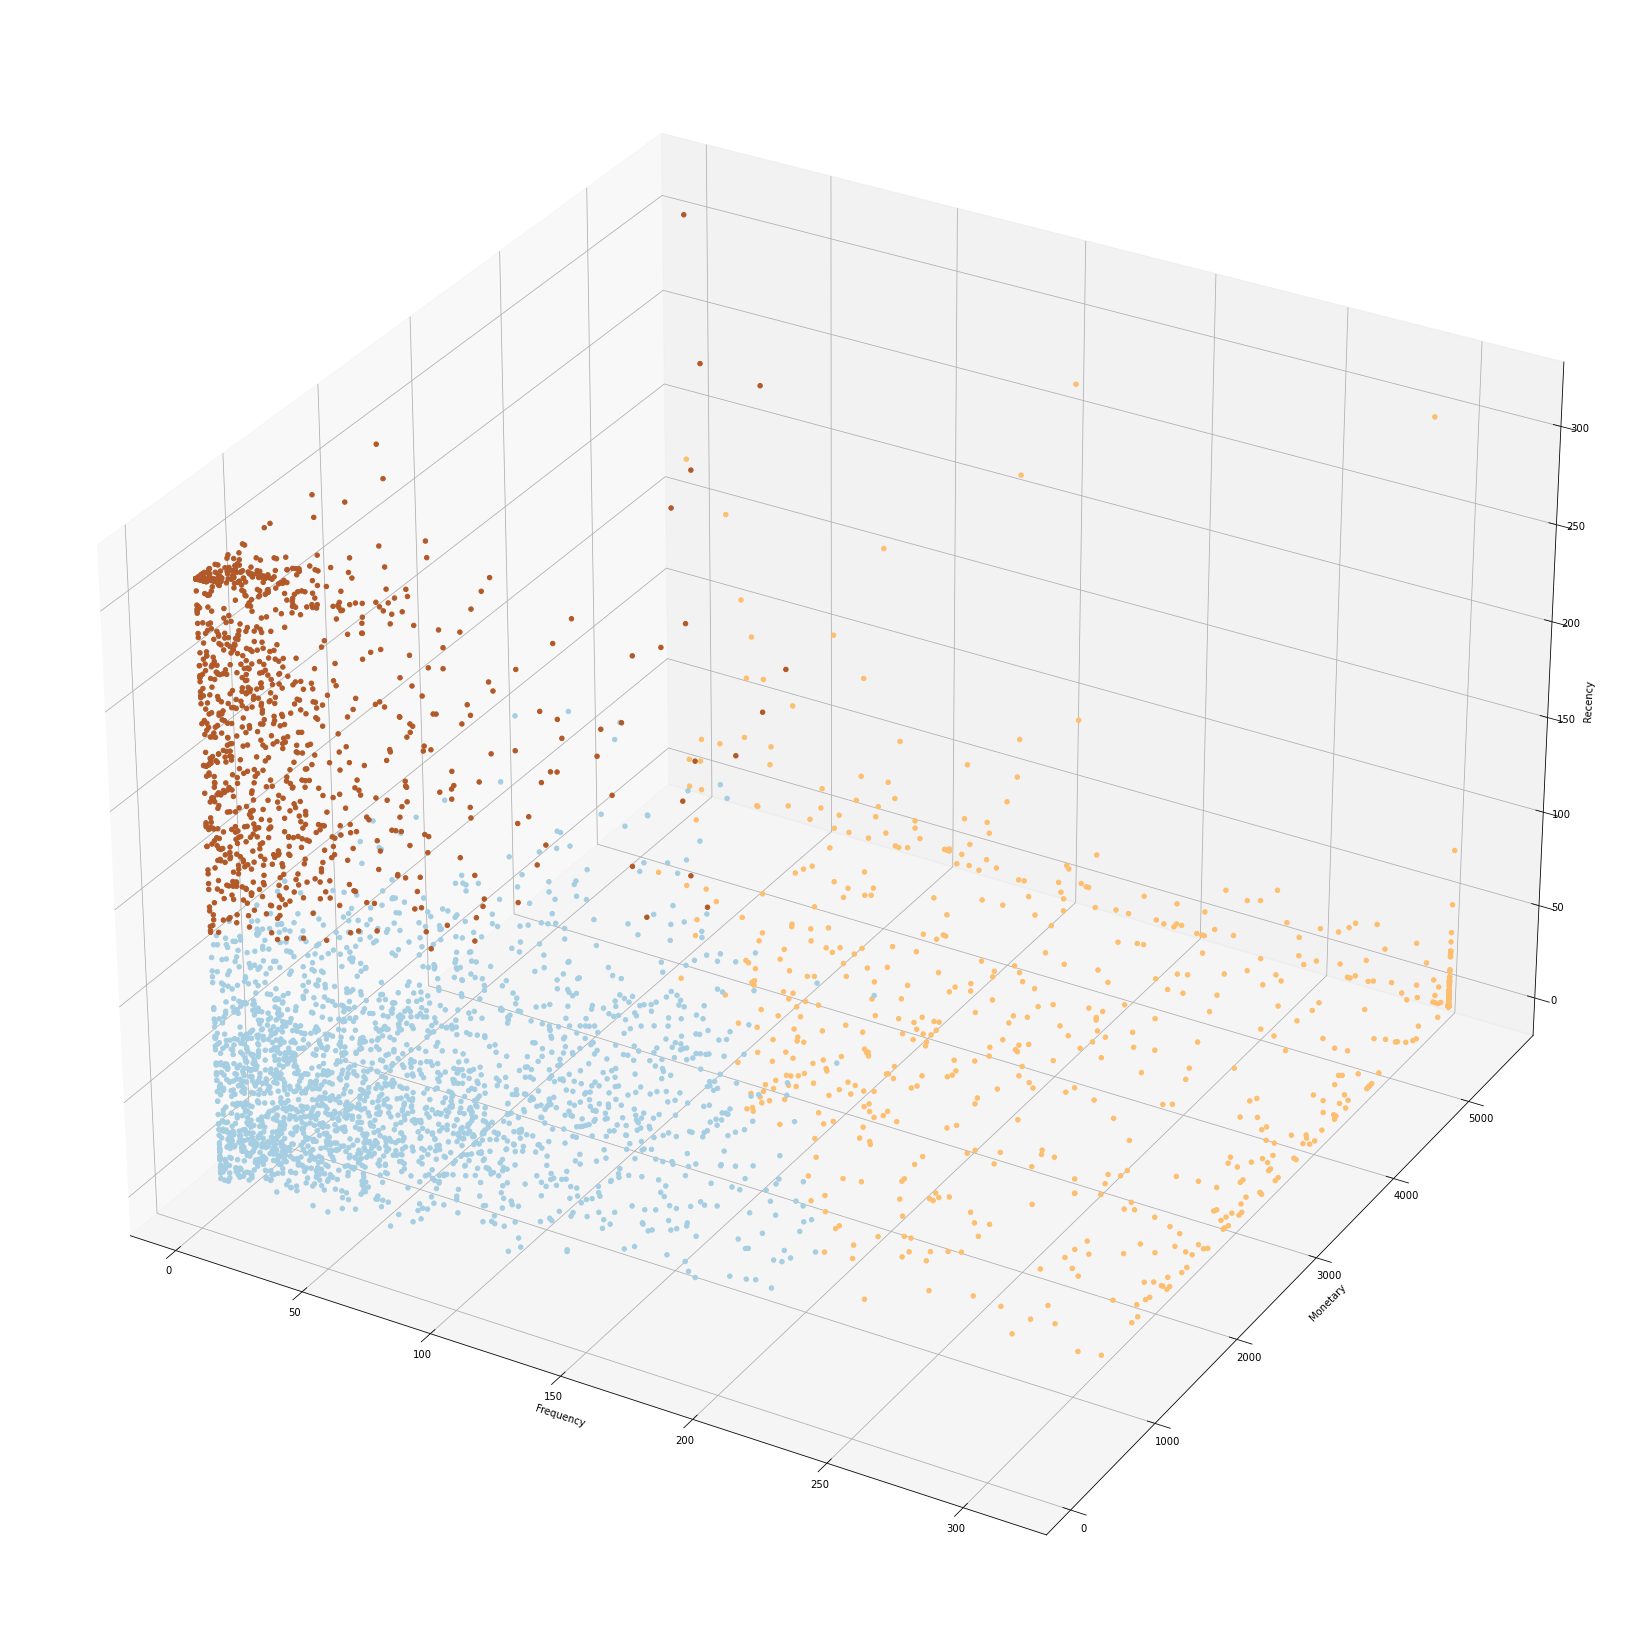

In [26]:
# plot the 3d graph
fig = plt.figure(figsize=[30,30])
ax = fig.add_subplot( projection = '3d')
x = customer_model2['Frequency']
y = customer_model2['Monetary']
z = customer_model2['Recency']
cmap = ListedColormap(sns.color_palette("Paired"))
ax.set_xlabel("Frequency")
ax.set_ylabel("Monetary")
ax.set_zlabel("Recency")   
ax.scatter(x, y, z, c = customer_model2['cluster_id'], cmap = cmap , alpha=1)
plt.show()

Comparing to the previous model, we can only see slight changes around the boundaries.

#### Evaluation on $k$

Similar with last K-means model, we want to how good the clustering is when $k=3$.

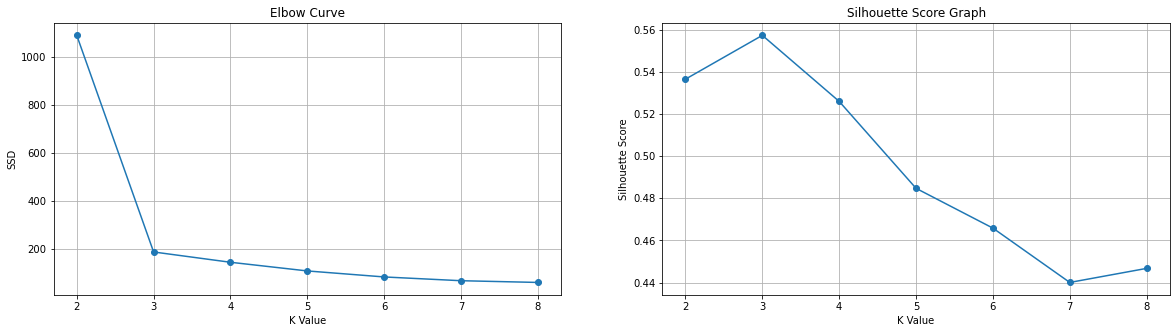

In [27]:
# compute ssd and sil scores
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7,8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50, random_state=42)
    kmeans.fit(df_pca_minmax)
    ssd.append(kmeans.inertia_)

sil_scores = []
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(df_pca_z)
    cluster_labels = kmeans.labels_
    sil_avg = silhouette_score(df_pca_z, cluster_labels)
    sil_scores.append(sil_avg)

#plot the graphs
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(range_n_clusters,ssd, marker = 'o')
plt.xlabel('K Value')
plt.ylabel('SSD')
plt.title('Elbow Curve')
plt.grid()

plt.subplot(1,2,2)
plt.plot(range_n_clusters,sil_scores, marker = 'o')
plt.xlabel('K Value')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Graph')
plt.grid()
plt.show()

 The best number of clustering once again corresponds with our business objective ($k=3$). 

### **DBSCAN with MinMax Normalisation**

Now we implement DBSCAN, start by finding the right value for hyperparameters $\epsilon$ and min sample.

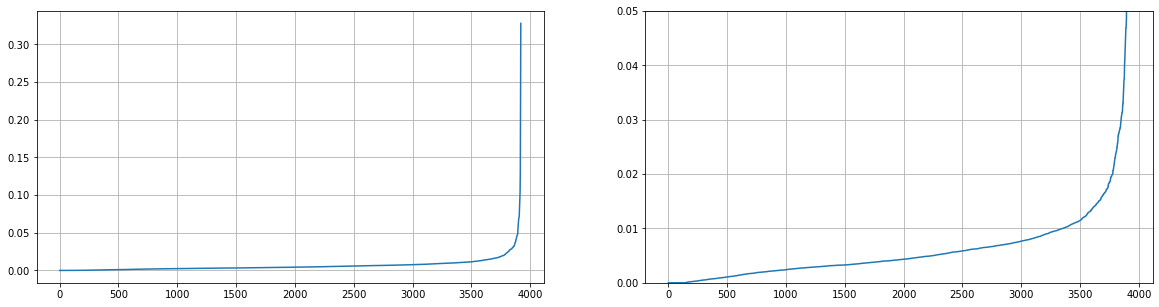

In [28]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df_pca_minmax)
distances, indices = nbrs.kneighbors(df_pca_minmax)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

# plot the graph
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.grid()
plt.plot(distances)

plt.subplot(1,2,2)
plt.grid()
plt.ylim(0,0.05)
plt.plot(distances)
plt.show()

The optimal value for $\epsilon$ will be found at the point of maximum curvature (Maklin, 2022), we will take $\epsilon = 0.015$. For min samples number, we choose it to be $4$ as we are using a 2D data (PCA) to run the model (Nabriya, 2022).

In [29]:
# set hyperparameters and run the model
from sklearn.cluster import DBSCAN
dbscan_1 = DBSCAN(eps = 0.015, min_samples = 4)
dbscan_1.fit(df_pca_minmax)

#add cluster labels
customer_model3 = customer.copy()
customer_model3['cluster_id'] = dbscan_1.labels_

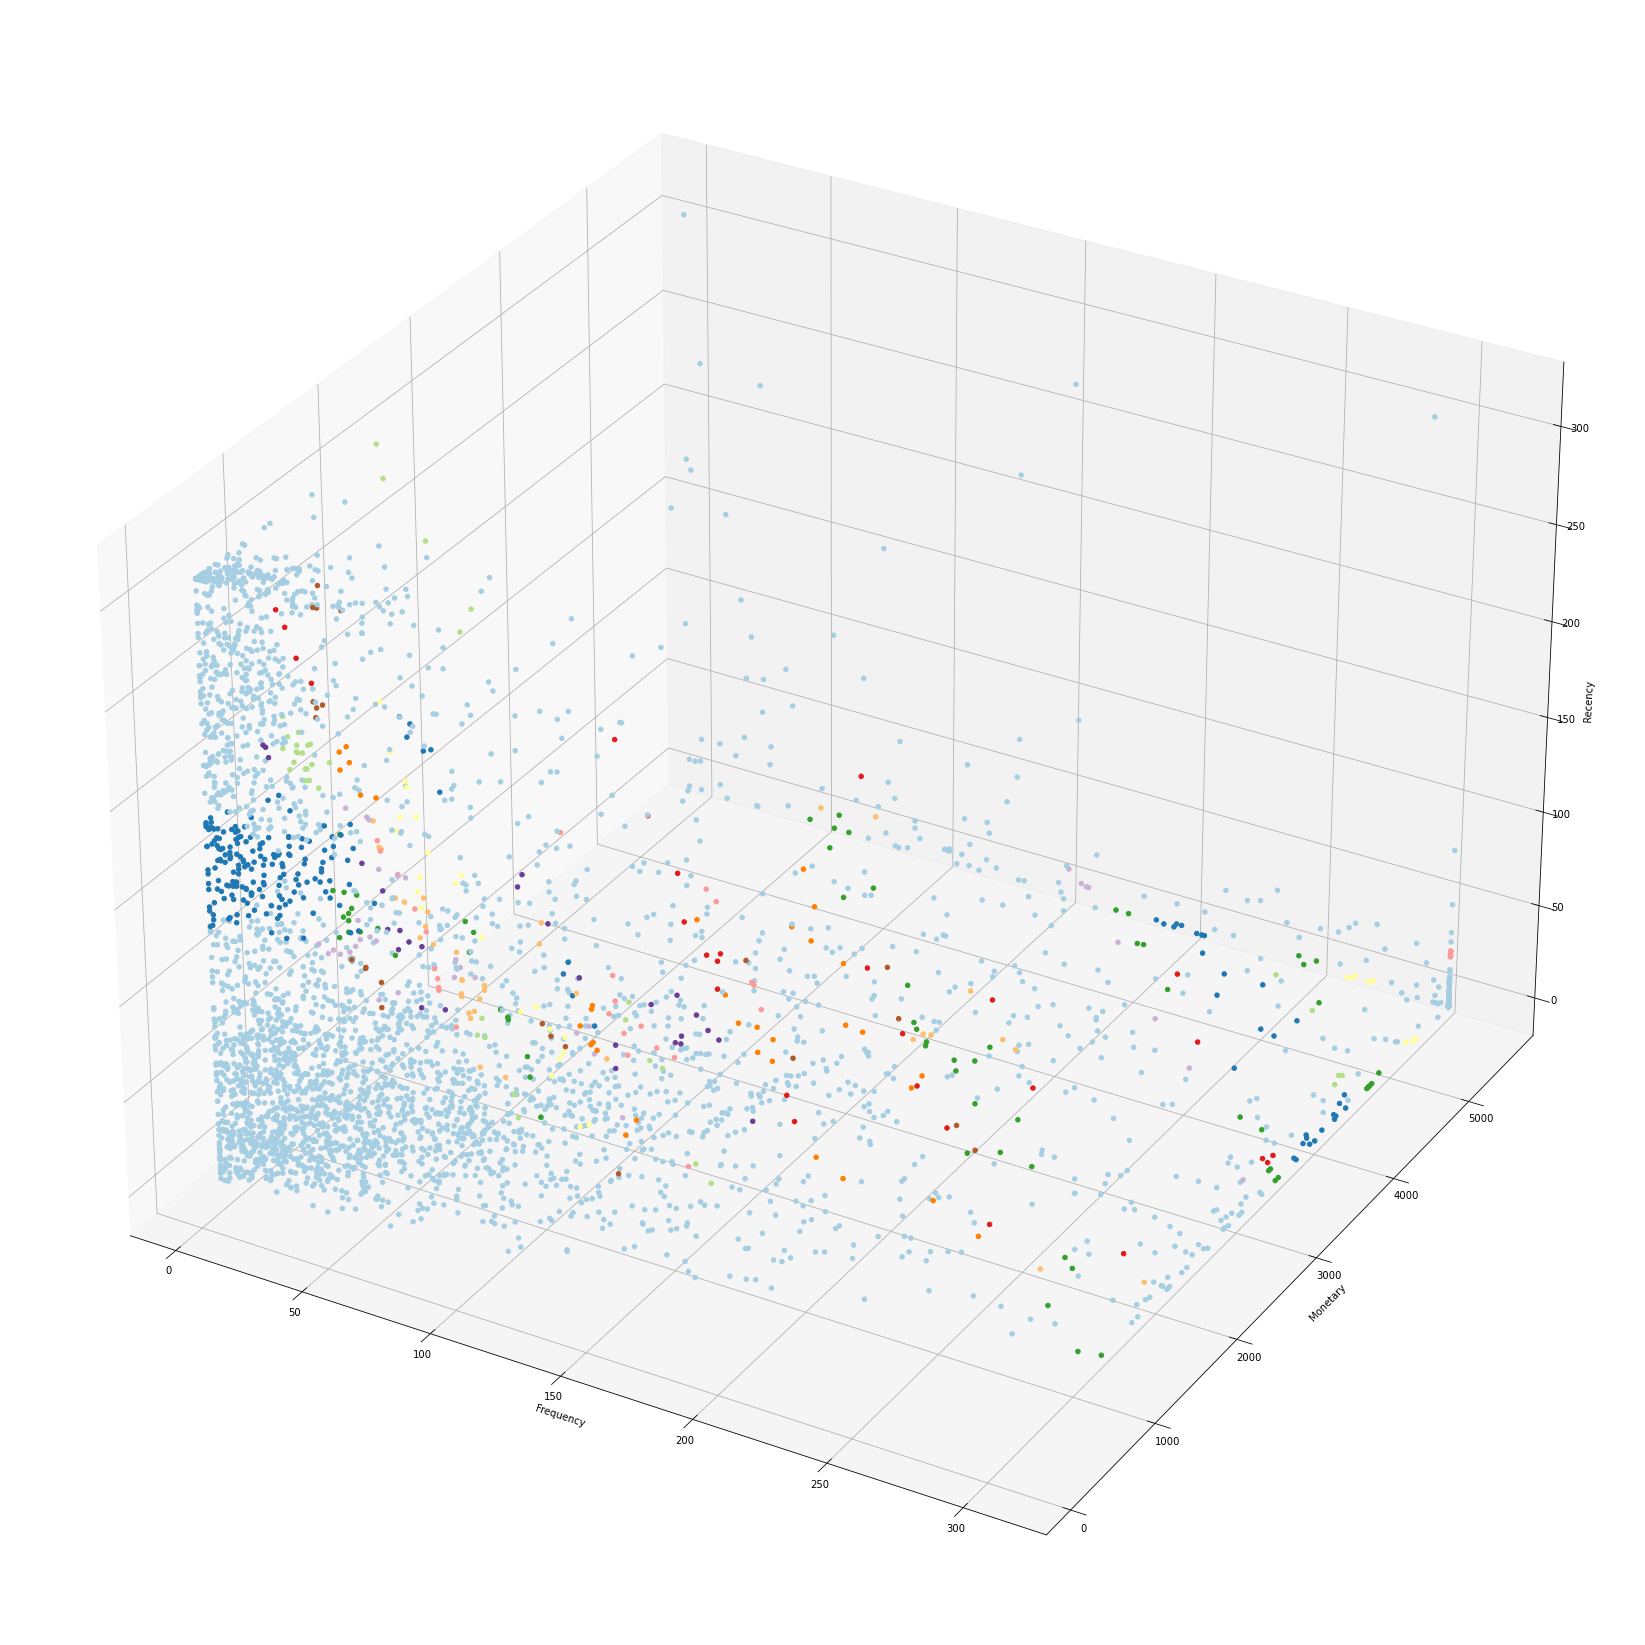

In [30]:
# plot the 3d graph
fig = plt.figure(figsize=[30,30])
ax = fig.add_subplot( projection = '3d')
x = customer_model3['Frequency']
y = customer_model3['Monetary']
z = customer_model3['Recency']
cmap = ListedColormap(sns.color_palette("Paired"))
ax.set_xlabel("Frequency")
ax.set_ylabel("Monetary")
ax.set_zlabel("Recency")   
ax.scatter(x, y, z, c = customer_model3['cluster_id'], cmap = cmap , alpha=1)
plt.show()

This clustering is not satisfying our business objective, we want the number of clusters to be around 3. After trying different values of $\epsilon$, I find the clustering is resonablely good when $\epsilon = 0.25$.

In [31]:
# epsilon = 0.25
dbscan_2 = DBSCAN(eps = 0.25, min_samples = 4)
dbscan_2.fit(df_pca_minmax)
customer_model4 = customer.copy()
customer_model4['cluster_id'] = dbscan_2.labels_

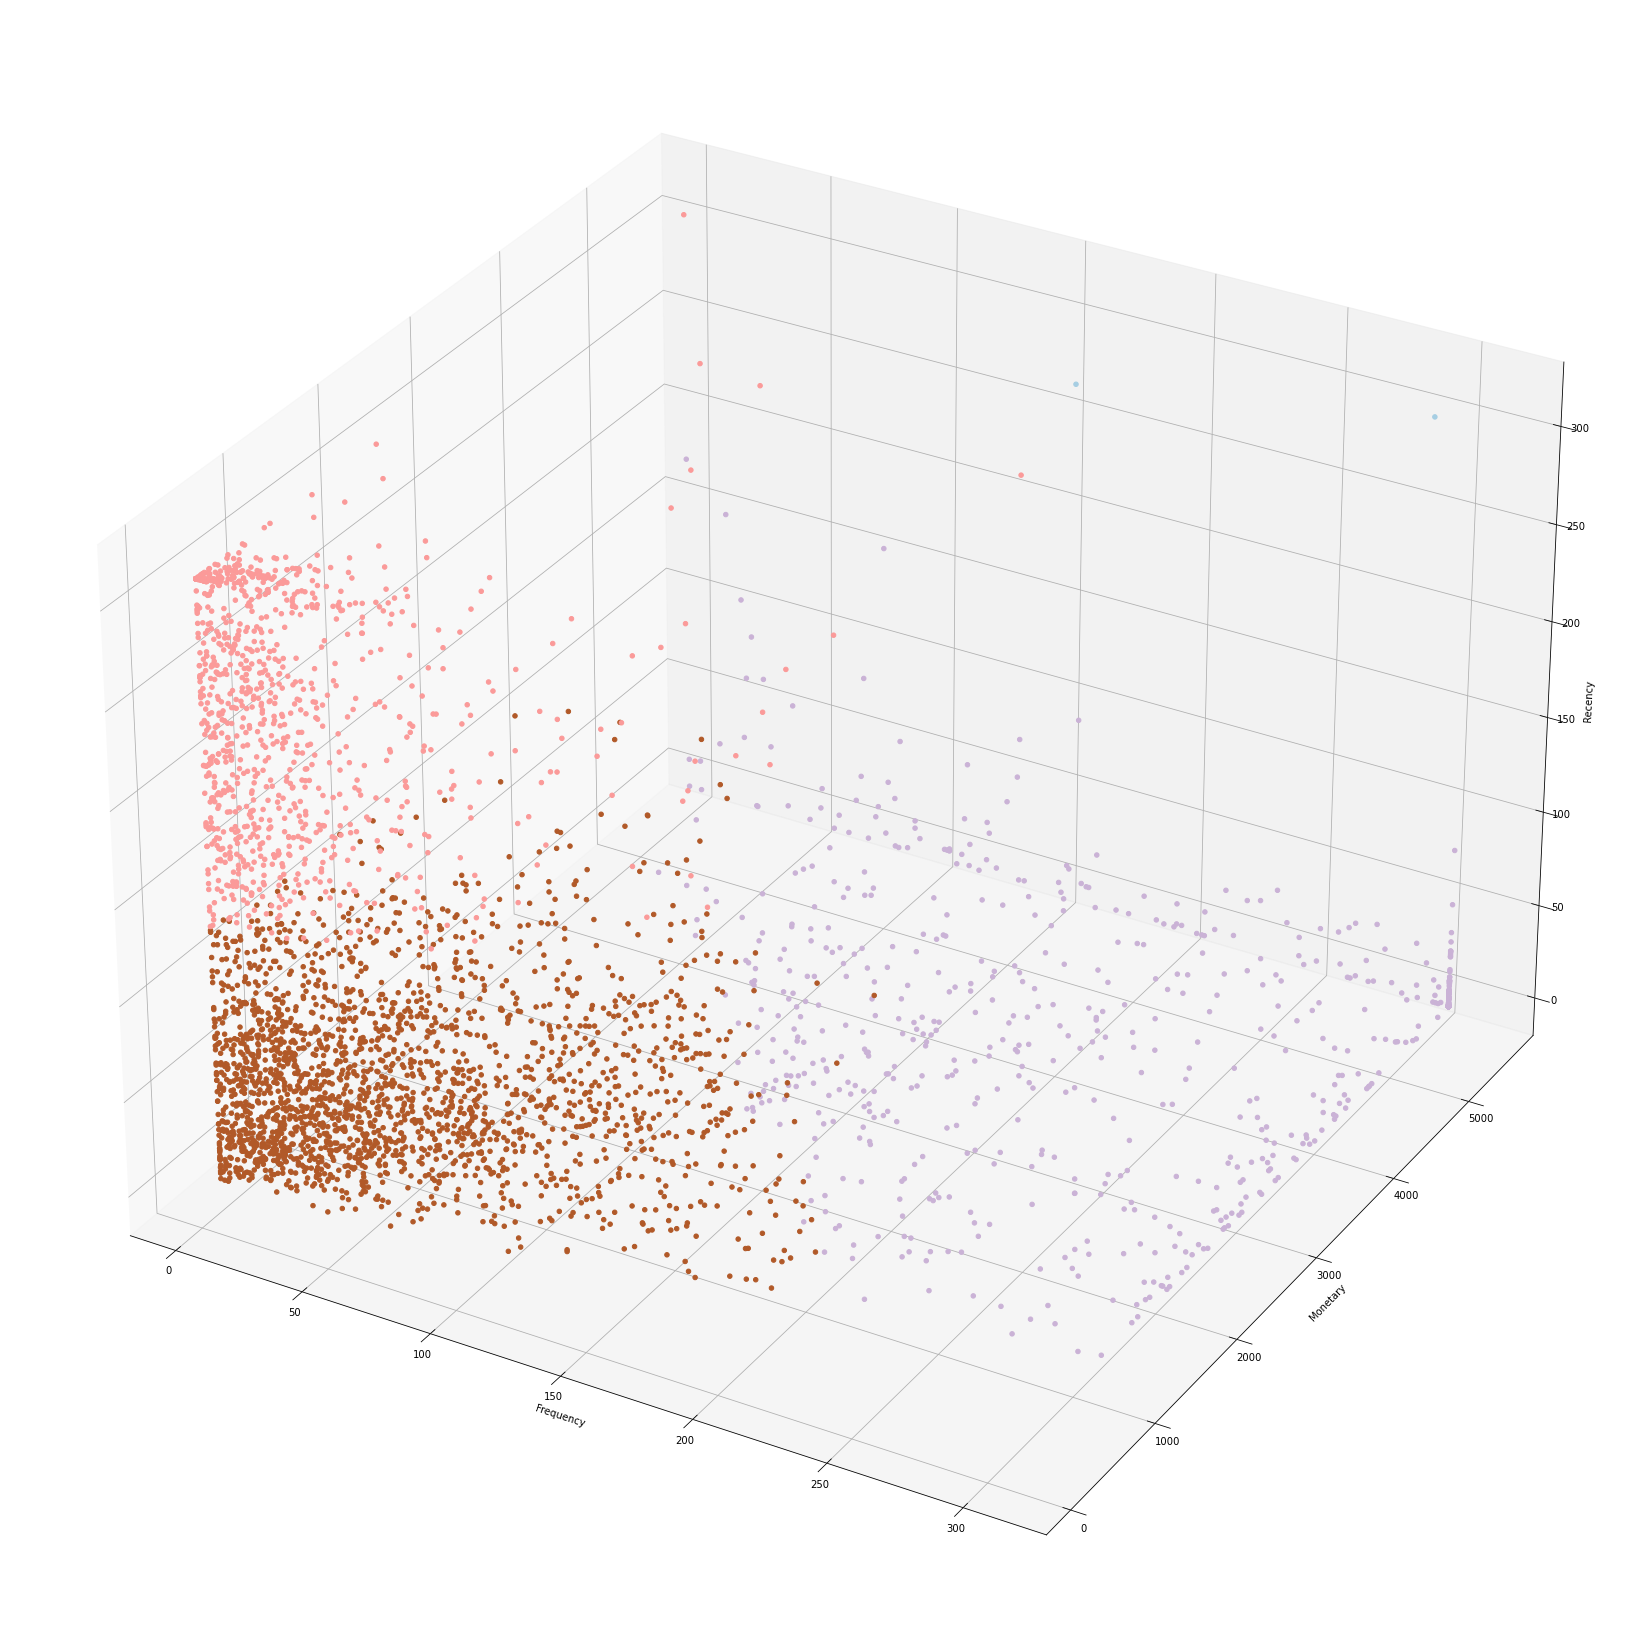

In [32]:
# plot the graph
fig = plt.figure(figsize=[30,30])
ax = fig.add_subplot( projection = '3d')
x = customer_model4['Frequency']
y = customer_model4['Monetary']
z = customer_model4['Recency']
cmap = ListedColormap(sns.color_palette("Paired"))
ax.set_xlabel("Frequency")
ax.set_ylabel("Monetary")
ax.set_zlabel("Recency")   
ax.scatter(x, y, z, c = customer_model4['cluster_id'], cmap = cmap , alpha=1)
plt.show()

DBSCAN appears to be much better than K-means, as it introduces outliers. Regions are separated clearly.

### **DBSCAN with Z-score Normalisation**

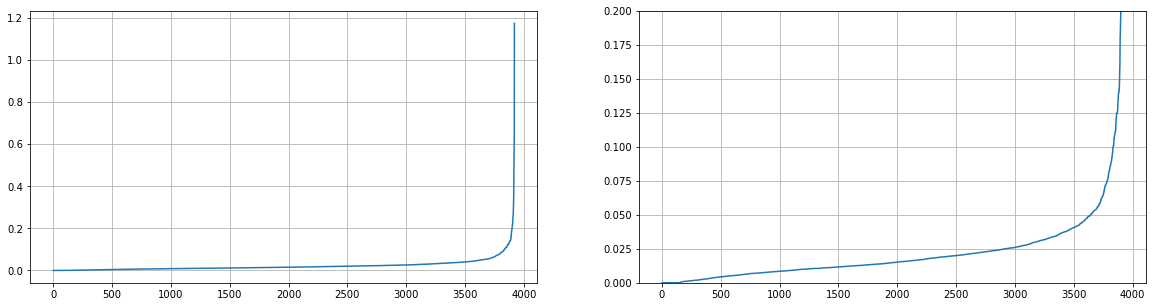

In [33]:
# find the best epsilon
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df_pca_z)
distances, indices = nbrs.kneighbors(df_pca_z)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

# plot the graph
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.grid()
plt.plot(distances)

plt.subplot(1,2,2)
plt.grid()
plt.ylim(0,0.2)
plt.plot(distances)
plt.show()

In [34]:
# set up the model and add labels
dbscan_3 = DBSCAN(eps = 0.05, min_samples = 4)
dbscan_3.fit(df_pca_z)
customer_model5 = customer.copy()
customer_model5['cluster_id'] = dbscan_3.labels_

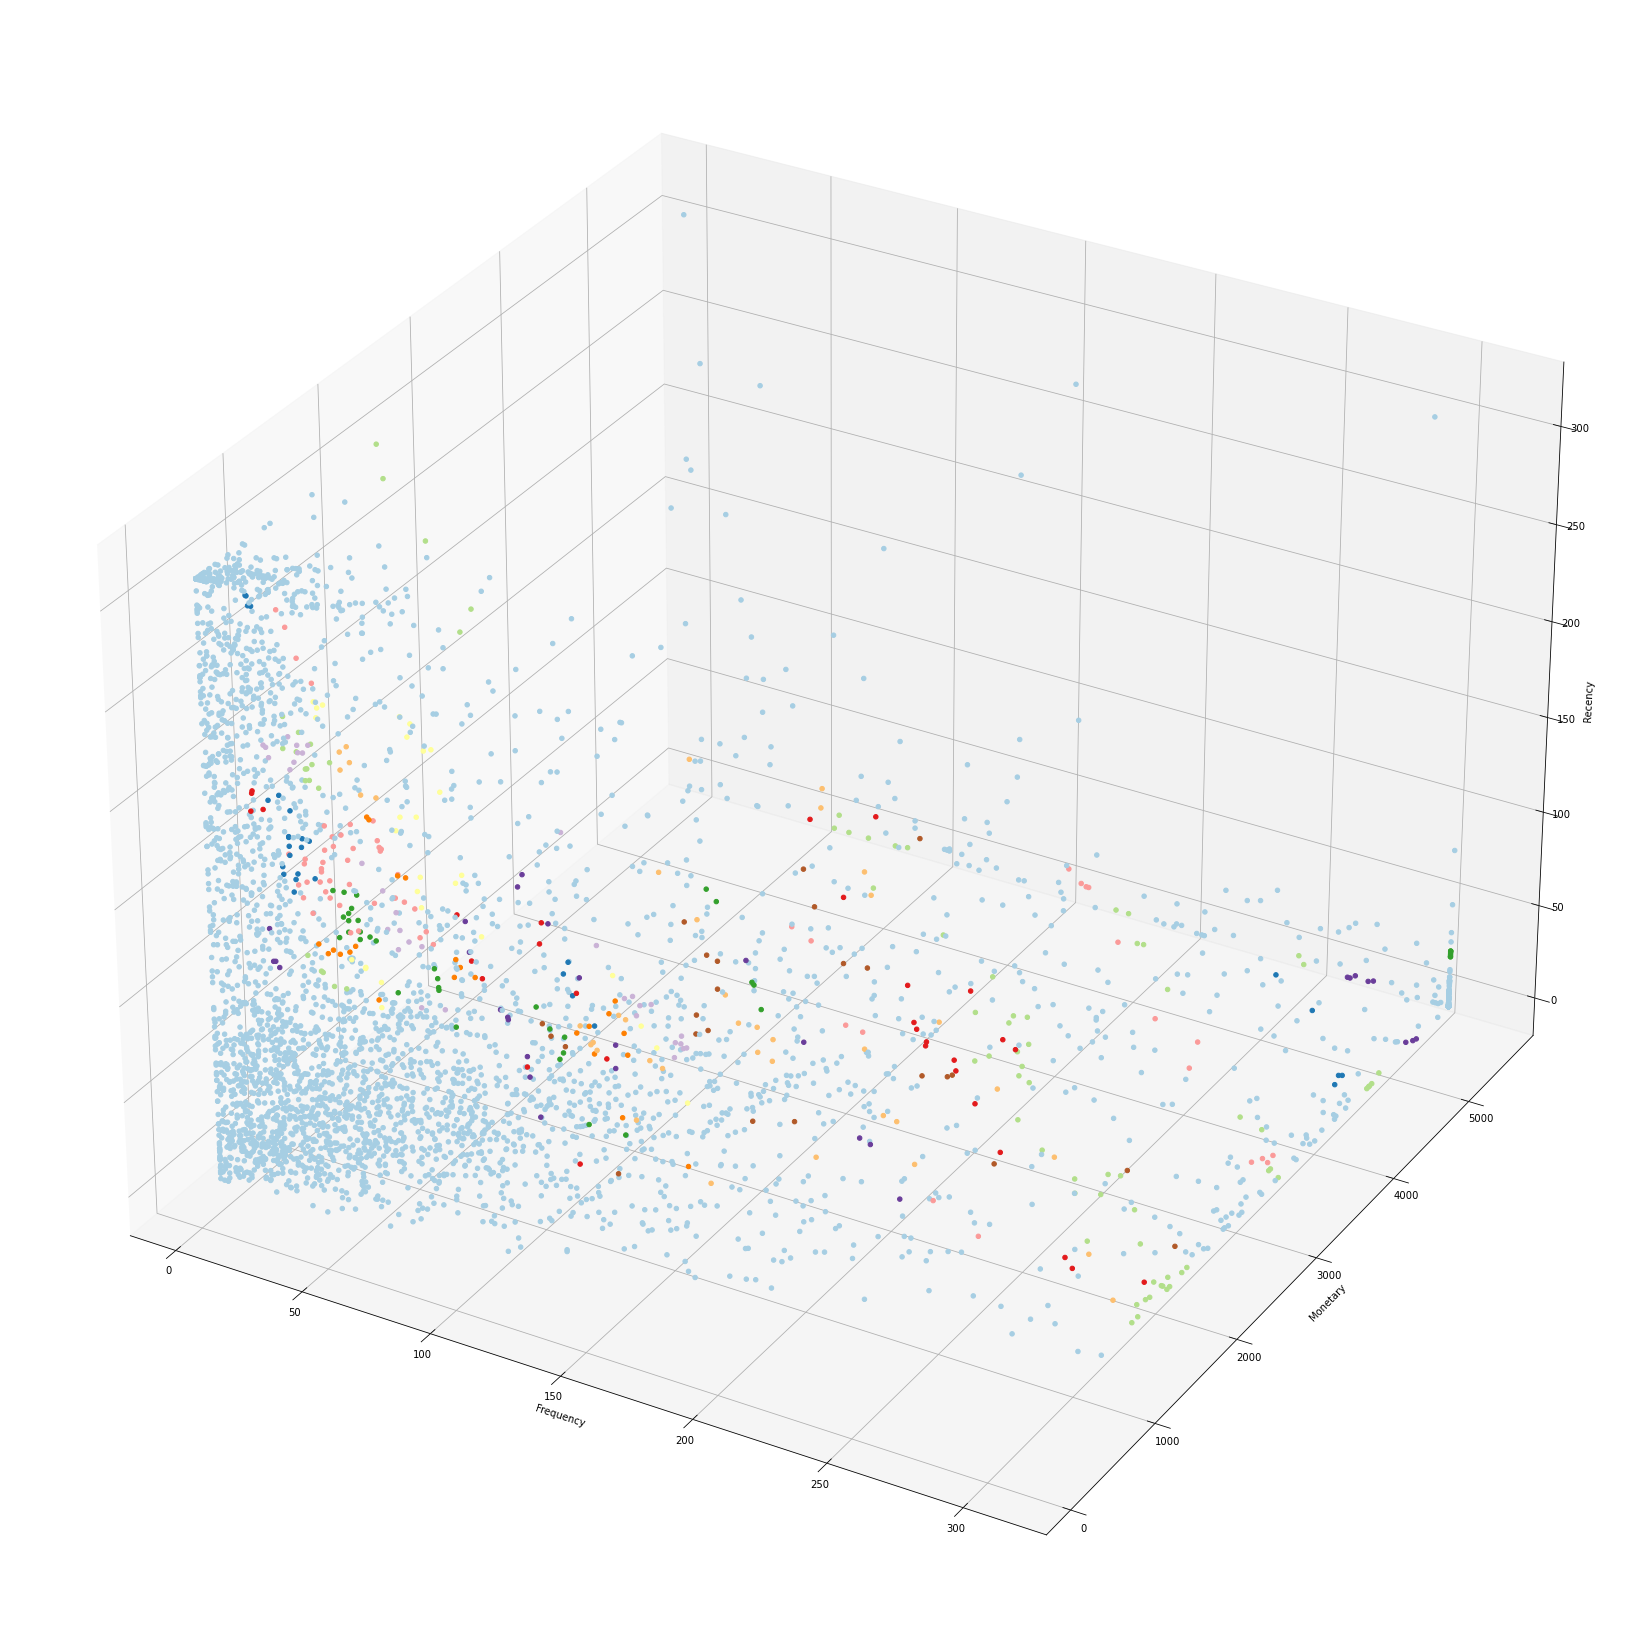

In [35]:
# plot the graph
fig = plt.figure(figsize=[30,30])
ax = fig.add_subplot( projection = '3d')
x = customer_model5['Frequency']
y = customer_model5['Monetary']
z = customer_model5['Recency']
cmap = ListedColormap(sns.color_palette("Paired"))
ax.set_xlabel("Frequency")
ax.set_ylabel("Monetary")
ax.set_zlabel("Recency")   
ax.scatter(x, y, z, c = customer_model5['cluster_id'], cmap = cmap , alpha=1)
plt.show()

Again, this does not satisfy our business objective. I then tried with different $\epsilon$ and min_samples values, but none of them look resonablely good. Our z-score normalised dataset may not work well on DBSCAN.

### **Agglomerative Hierarchical Clustering with MinMax Normalisation**

In [36]:
# set up the model and add labels
hierachical_1 = AgglomerativeClustering(n_clusters=3,affinity='euclidean', linkage='single')
hierachical_1.fit_predict(df_pca_minmax)
customer_model6 = customer.copy()
customer_model6['cluster_id'] = hierachical_1.labels_

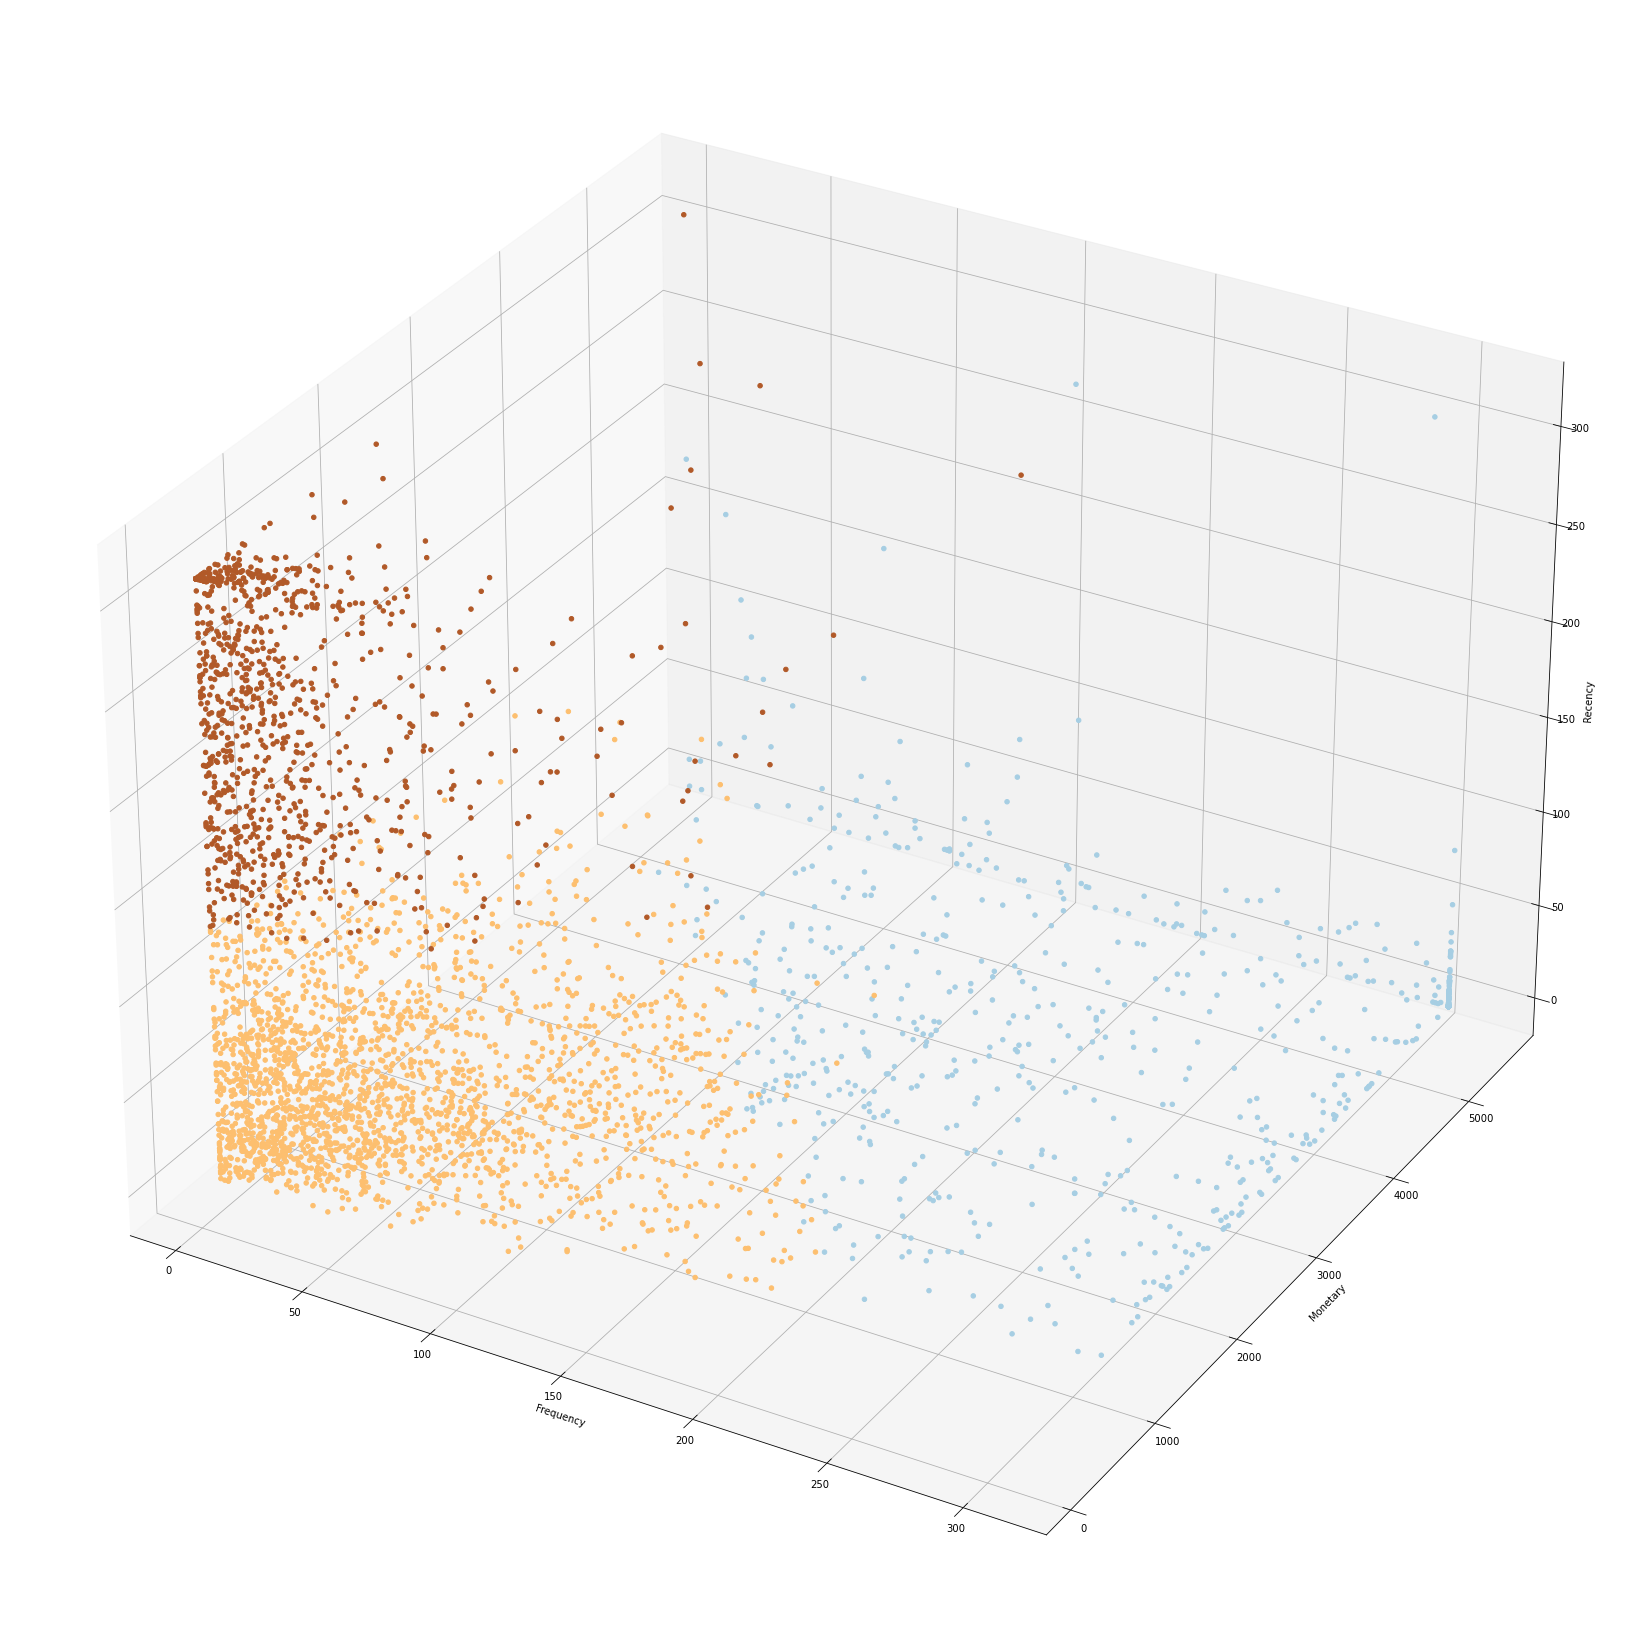

In [37]:
# plot the graph
fig = plt.figure(figsize=[30,30])
ax = fig.add_subplot( projection = '3d')
x = customer_model6['Frequency']
y = customer_model6['Monetary']
z = customer_model6['Recency']
cmap = ListedColormap(sns.color_palette("Paired"))
ax.set_xlabel("Frequency")
ax.set_ylabel("Monetary")
ax.set_zlabel("Recency")   
ax.scatter(x, y, z, c = customer_model6['cluster_id'], cmap = cmap , alpha=1)
plt.show()

### **Agglomerative Hierarchical Clustering with Z-score Normalisation**

In [38]:
# set up the model and add labels
hierachical_2 = AgglomerativeClustering(n_clusters=3,affinity='euclidean', linkage='single')
hierachical_2.fit_predict(df_pca_z)
customer_model7 = customer.copy()
customer_model7['cluster_id'] = hierachical_2.labels_

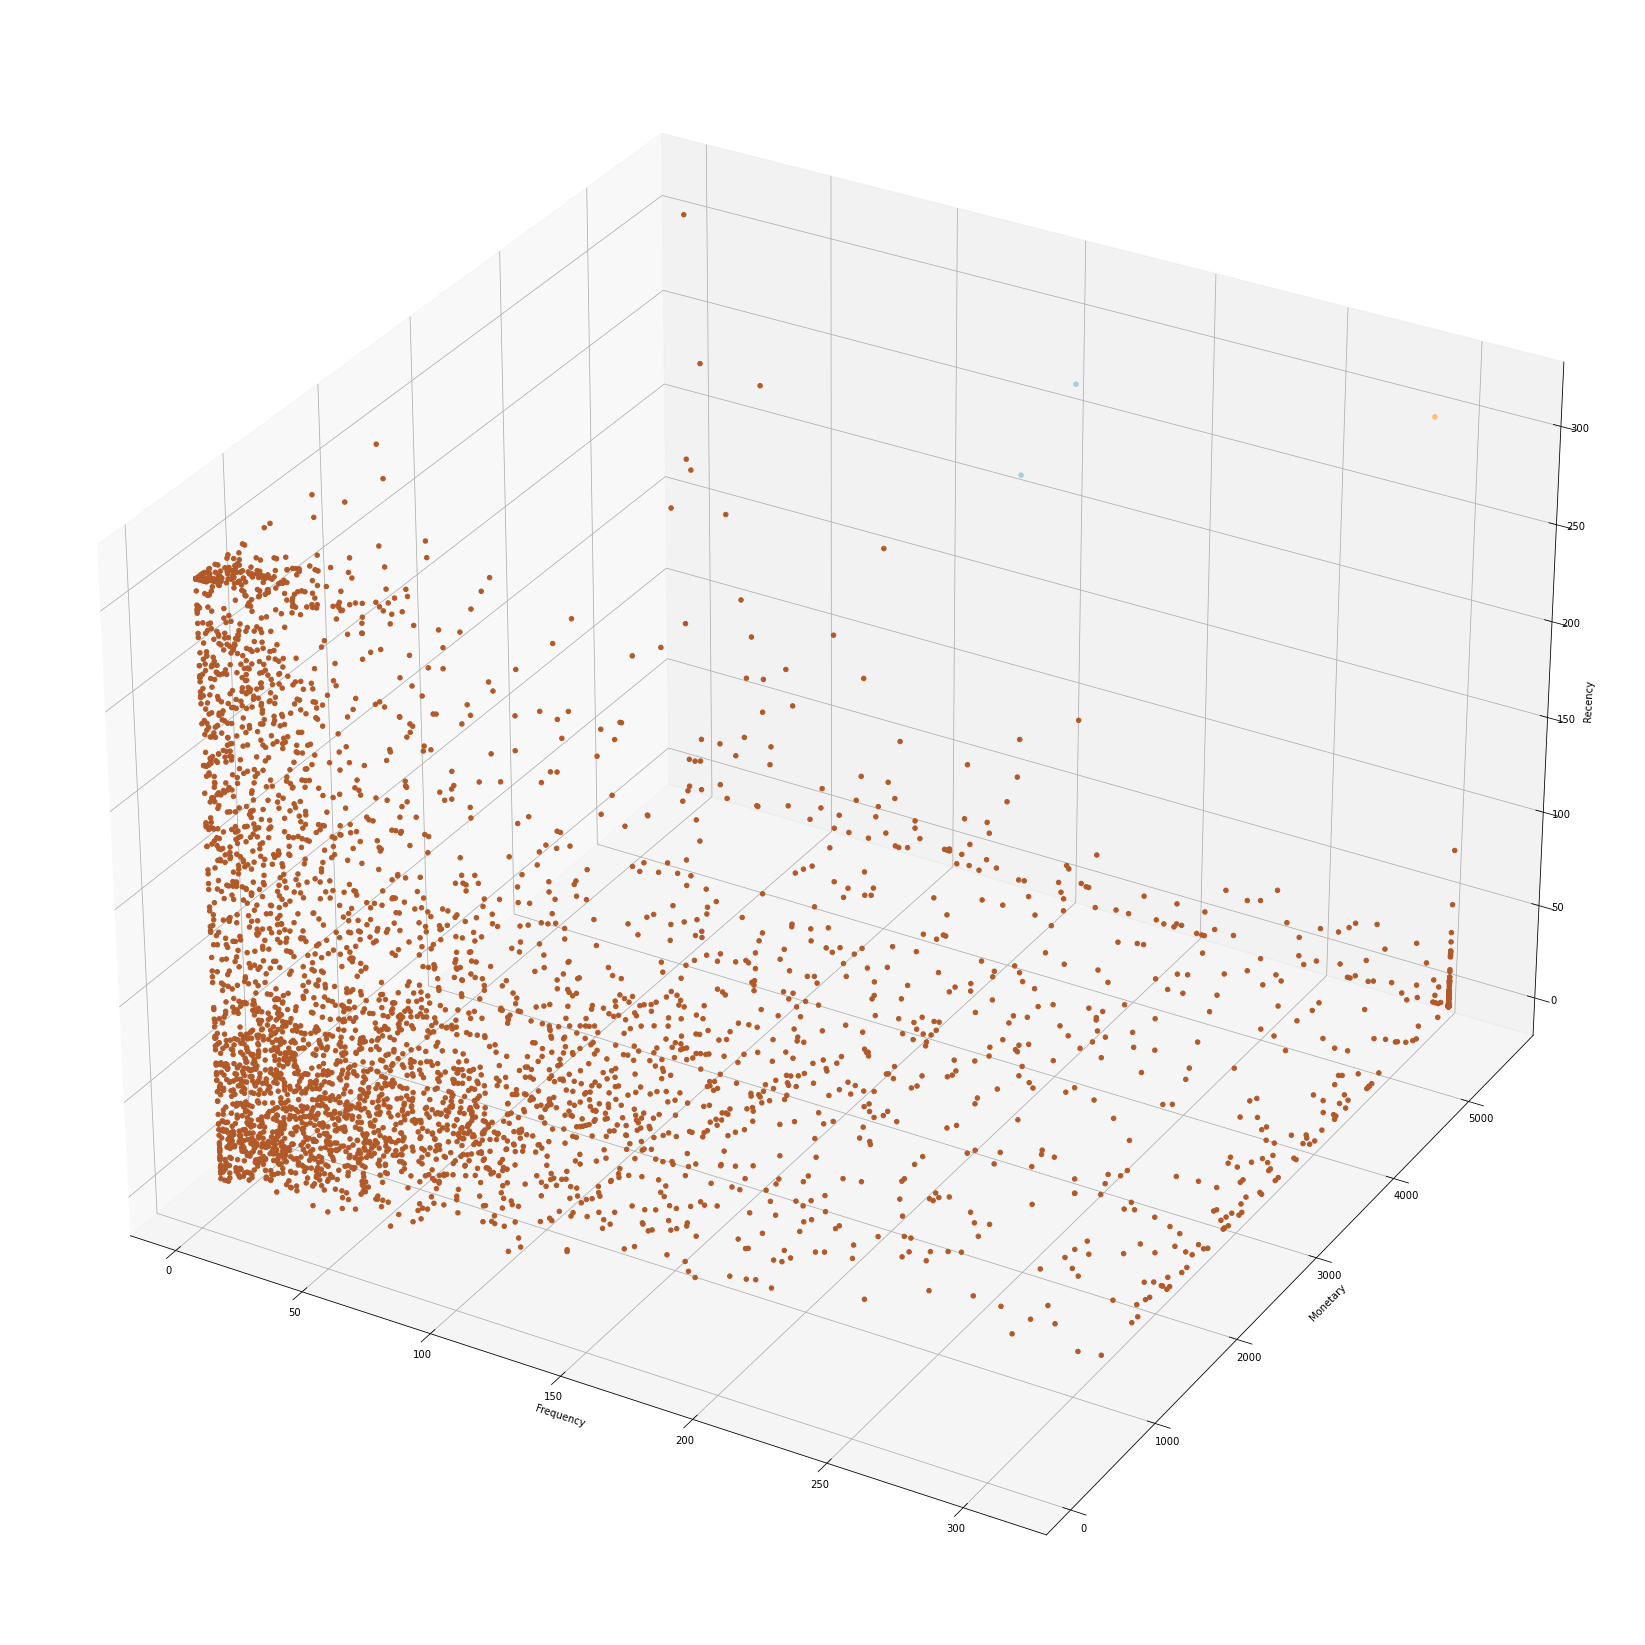

In [39]:
# plot the graph
fig = plt.figure(figsize=[30,30])
ax = fig.add_subplot( projection = '3d')
x = customer_model7['Frequency']
y = customer_model7['Monetary']
z = customer_model7['Recency']
cmap = ListedColormap(sns.color_palette("Paired"))
ax.set_xlabel("Frequency")
ax.set_ylabel("Monetary")
ax.set_zlabel("Recency")   
ax.scatter(x, y, z, c = customer_model7['cluster_id'], cmap = cmap , alpha=1)
plt.show()

Agglomerative hierarchical clustering does not perform well on our z-score normalised data at all.

### **Gausian Mixture with MinMax Normalisation**

In [40]:
# set up the model and add labels
gmm_1 = GaussianMixture(n_components=3, random_state = 42)
gmm_1.fit(df_pca_minmax)
customer_model8 = customer.copy()
customer_model8['cluster_id'] =  gmm_1.predict(df_pca_minmax)

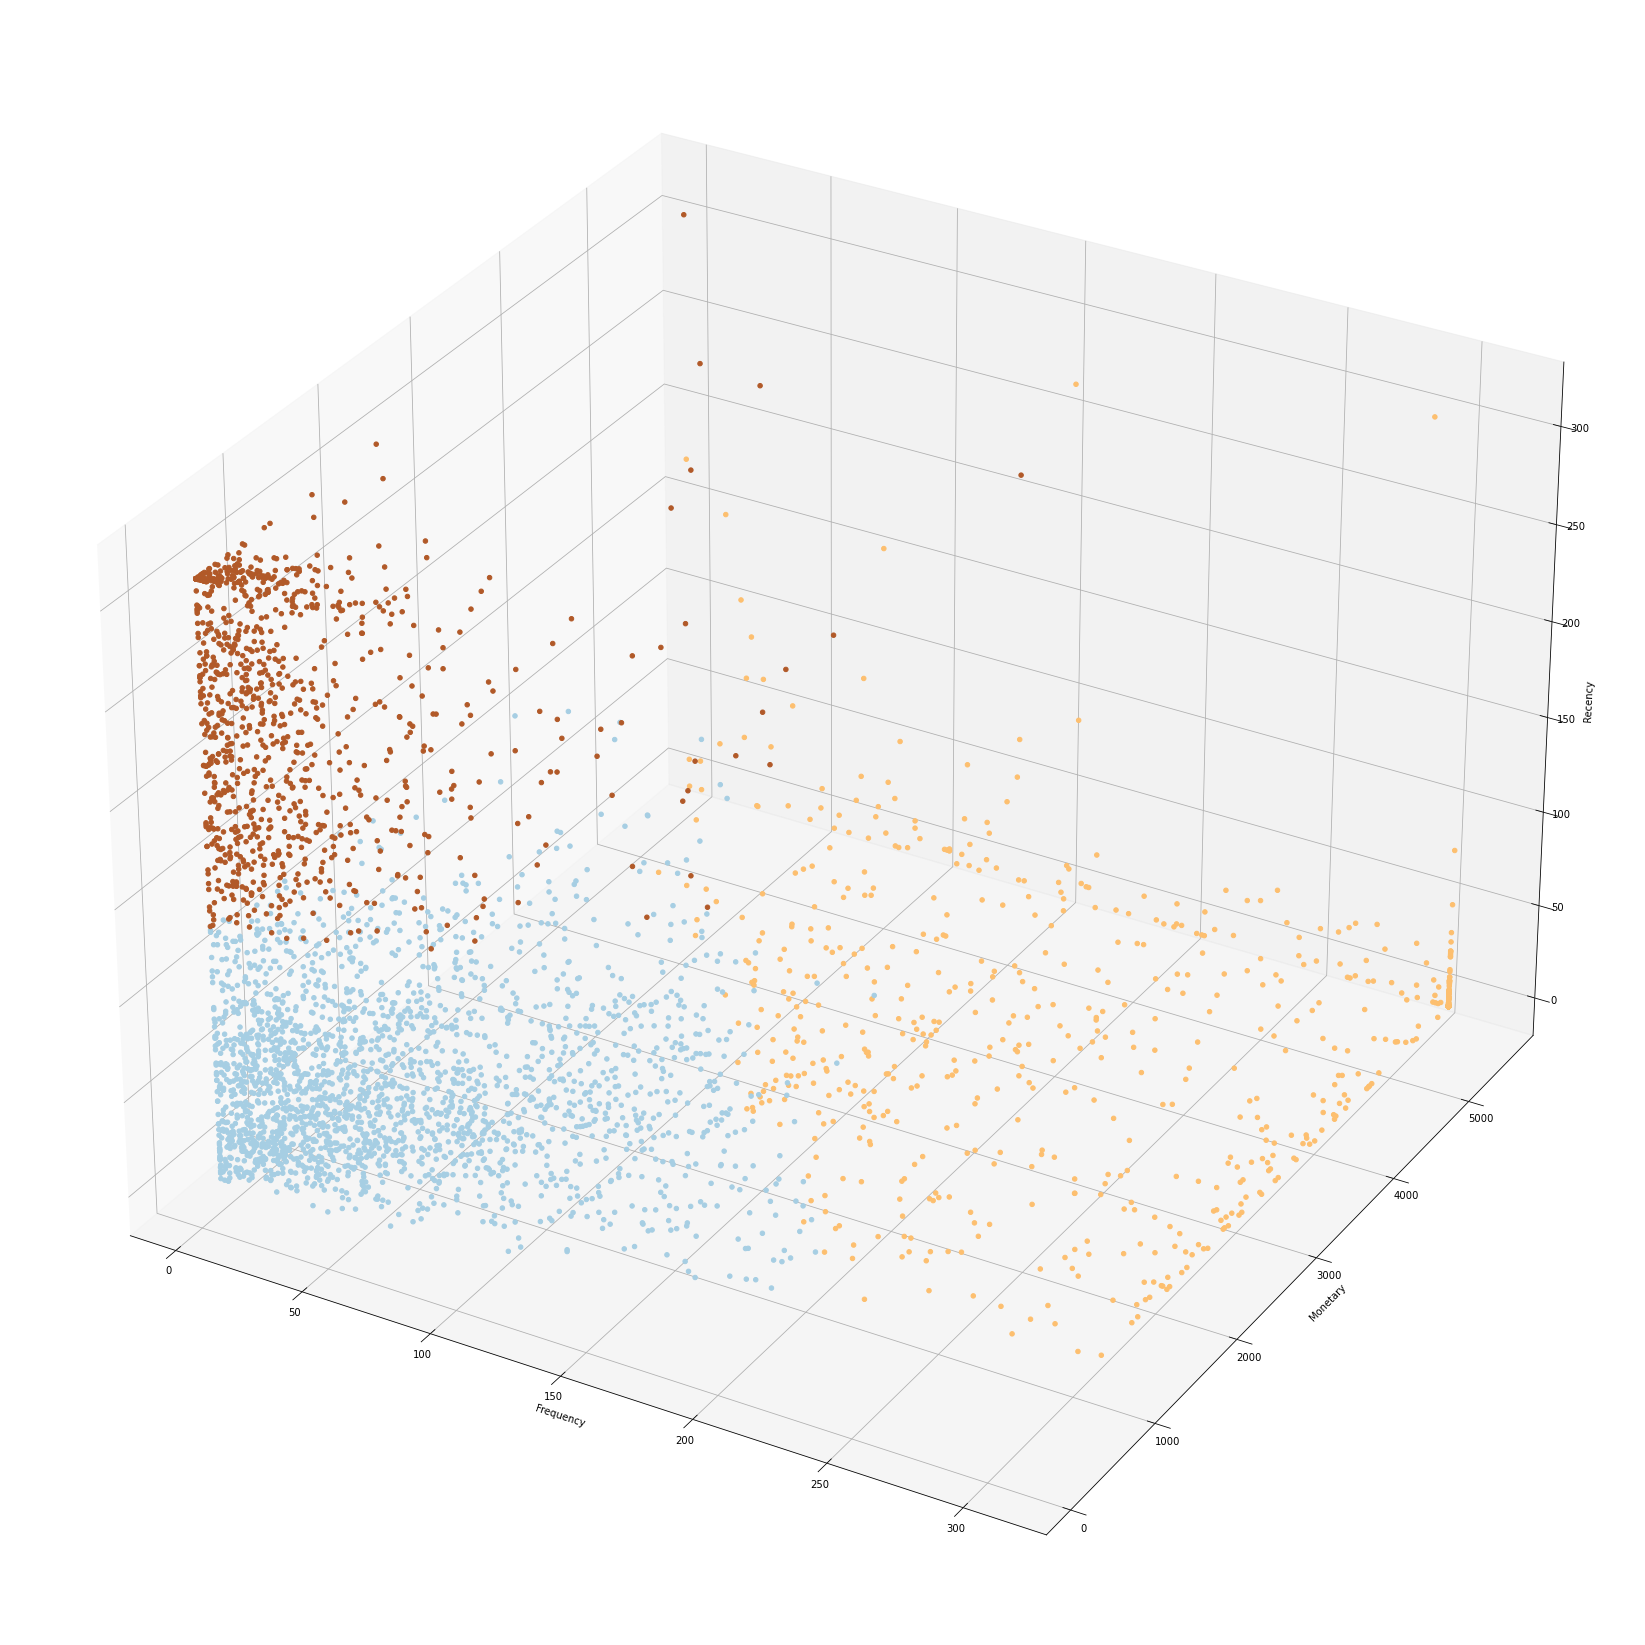

In [41]:
# plot the graph
fig = plt.figure(figsize=[30,30])
ax = fig.add_subplot( projection = '3d')
x = customer_model8['Frequency']
y = customer_model8['Monetary']
z = customer_model8['Recency']
cmap = ListedColormap(sns.color_palette("Paired"))
ax.set_xlabel("Frequency")
ax.set_ylabel("Monetary")
ax.set_zlabel("Recency")   
ax.scatter(x, y, z, c = customer_model8['cluster_id'], cmap = cmap , alpha=1)
plt.show()

### **Gausian Mixture with Z-score Normalisation**

In [42]:
# set up the model and add labels
gmm_2 = GaussianMixture(n_components=3, random_state = 42)
gmm_2.fit(df_pca_z)
customer_model9 = customer.copy()
customer_model9['cluster_id'] =  gmm_2.predict(df_pca_z)

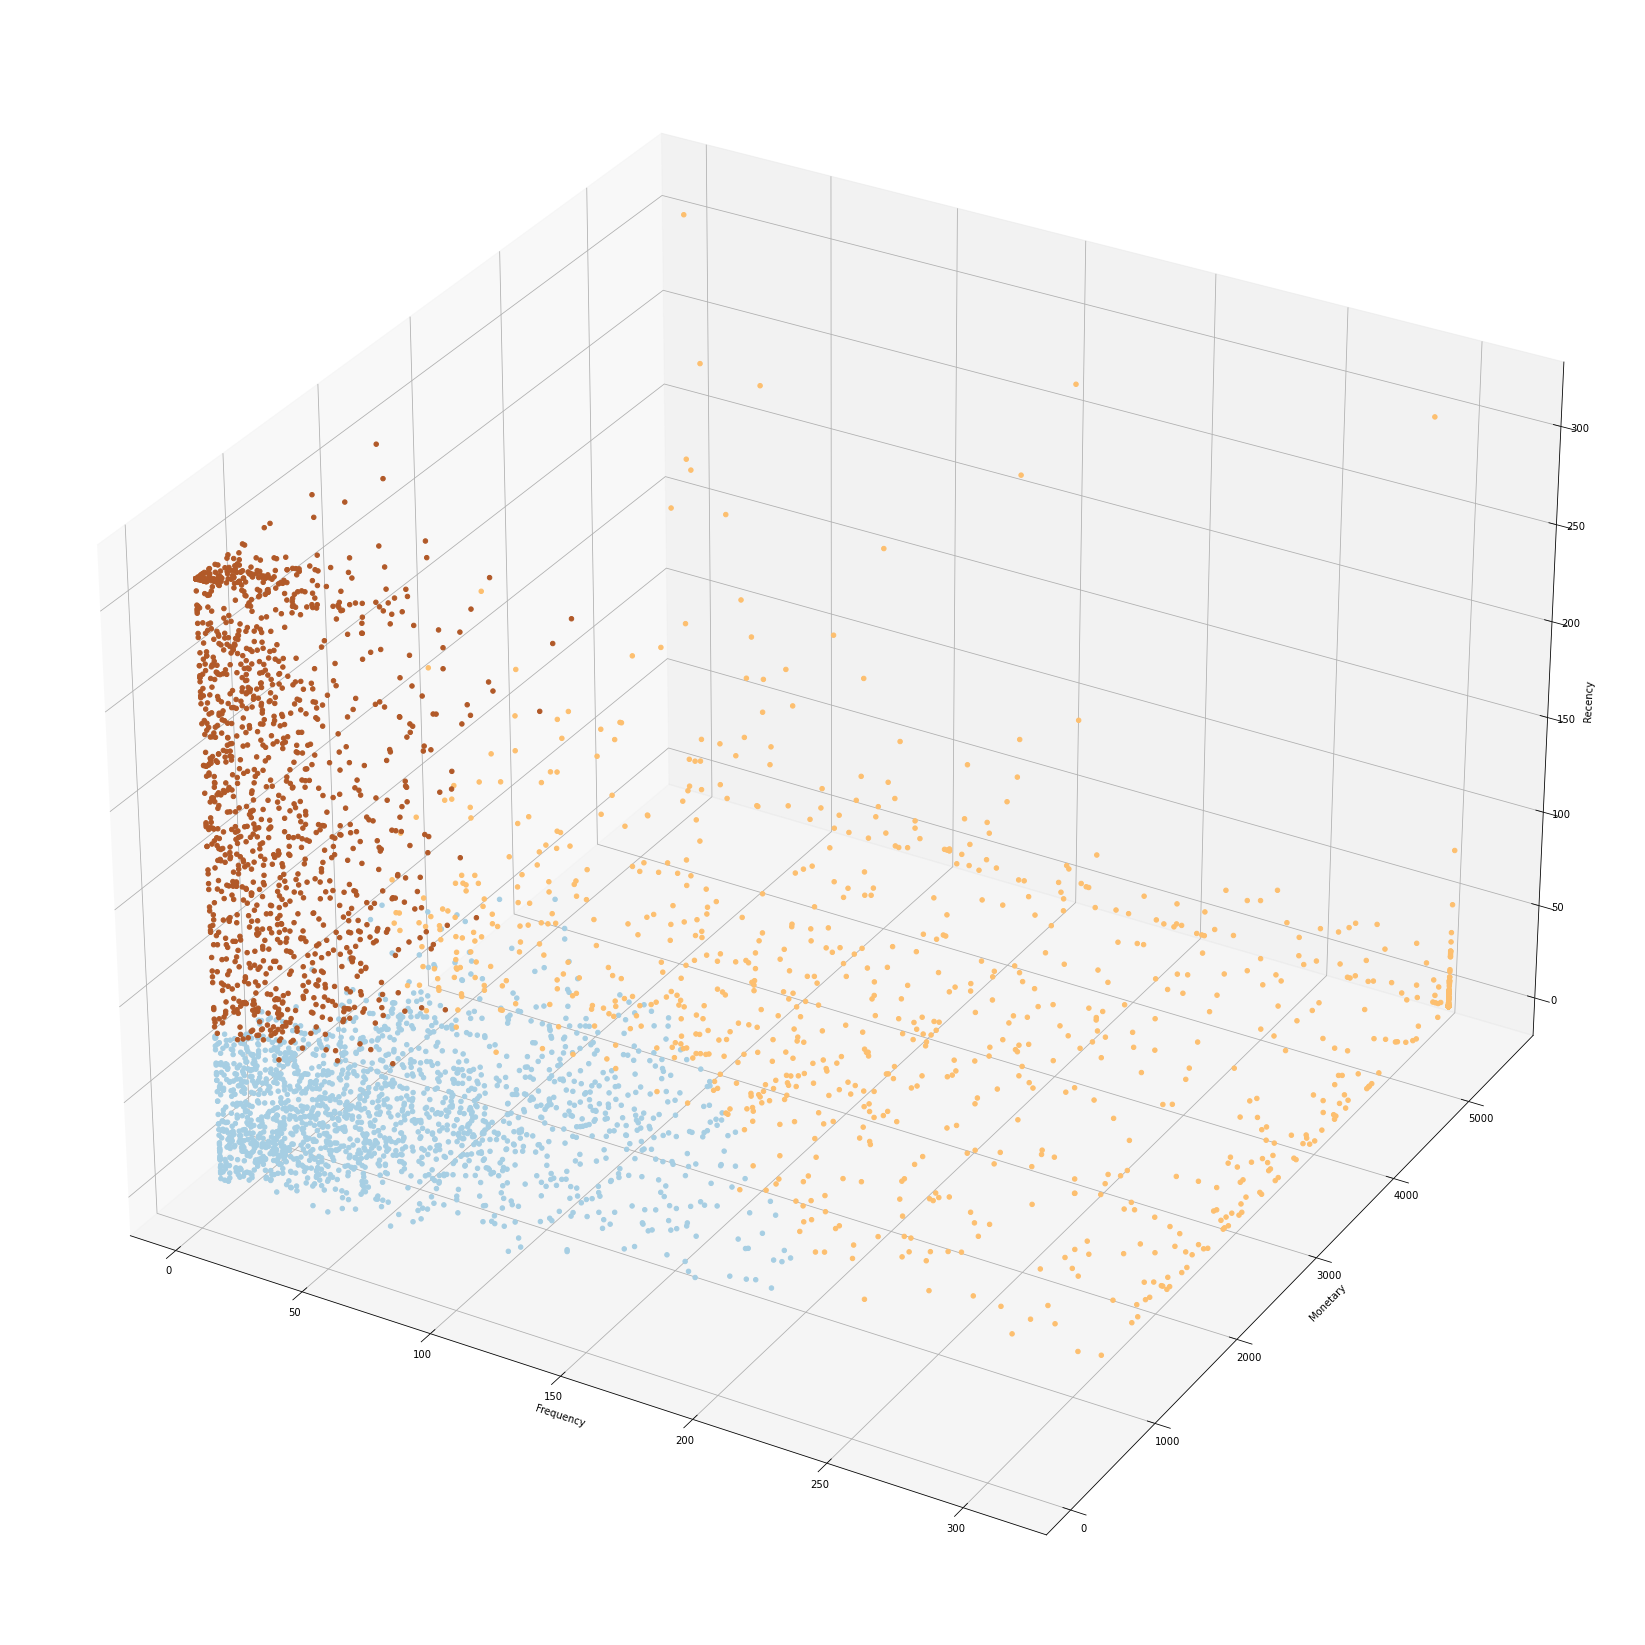

In [43]:
# plot the graph
fig = plt.figure(figsize=[30,30])
ax = fig.add_subplot( projection = '3d')
x = customer_model9['Frequency']
y = customer_model9['Monetary']
z = customer_model9['Recency']
cmap = ListedColormap(sns.color_palette("Paired"))
ax.set_xlabel("Frequency")
ax.set_ylabel("Monetary")
ax.set_zlabel("Recency")   
ax.scatter(x, y, z, c = customer_model9['cluster_id'], cmap = cmap , alpha=1)
plt.show()

## **Model Evaluation**

### Best Model Selection

To evaluate the performance of our models, we will consider two metrics - Davies Bouldin score and Silhouette score.

In [44]:
# calculate all metrics 
ds_1 = davies_bouldin_score(df_pca_minmax, customer_model1['cluster_id'])
ss_1 = silhouette_score(df_pca_minmax, customer_model1['cluster_id'])

ds_2 = davies_bouldin_score(df_pca_z, customer_model2['cluster_id'])
ss_2 = silhouette_score(df_pca_z, customer_model2['cluster_id'])

ds_3 = davies_bouldin_score(df_pca_minmax, customer_model3['cluster_id'])
ss_3 = silhouette_score(df_pca_minmax, customer_model3['cluster_id'])

ds_4 = davies_bouldin_score(df_pca_minmax, customer_model4['cluster_id'])
ss_4 = silhouette_score(df_pca_minmax, customer_model4['cluster_id'])

ds_5 = davies_bouldin_score(df_pca_z, customer_model5['cluster_id'])
ss_5 = silhouette_score(df_pca_z, customer_model5['cluster_id'])

ds_6 = davies_bouldin_score(df_pca_minmax, customer_model6['cluster_id'])
ss_6 = silhouette_score(df_pca_minmax, customer_model6['cluster_id'])

ds_7 = davies_bouldin_score(df_pca_z, customer_model7['cluster_id'])
ss_7 = silhouette_score(df_pca_z, customer_model7['cluster_id'])

ds_8 = davies_bouldin_score(df_pca_minmax, customer_model8['cluster_id'])
ss_8 = silhouette_score(df_pca_minmax, customer_model8['cluster_id'])

ds_9 = davies_bouldin_score(df_pca_z, customer_model9['cluster_id'])
ss_9 = silhouette_score(df_pca_z, customer_model9['cluster_id'])

In [45]:
# construct a dataframe for metrics
metric_table = pd.DataFrame(data=[[ds_1,ds_2,ds_3,ds_4,ds_5,ds_6,ds_7,ds_8,ds_9],
                                  [ss_1,ss_2,ss_3,ss_4,ss_5,ss_6,ss_7,ss_8,ss_9]], 
                                  columns=['model1','model2', 'model3','model4','model5','model6','model7','model8','model9'], 
                                  index=['Davies Bouldin Score','Silhouette Score'])
metric_table

model1    model2    model3    model4    model5  \
Davies Bouldin Score  0.303244  0.584097  1.115904  0.381608  1.723935   
Silhouette Score      0.792312  0.557307 -0.221442  0.769490 -0.491531   

                        model6    model7    model8    model9  
Davies Bouldin Score  0.303244  0.453539  0.303244  0.721831  
Silhouette Score      0.792312  0.446069  0.792312  0.450274

A good clustering model will have a low Davies Bouldin score (sklearn.metrics.davies_bouldin_score, 2022) and a high Silhouette score (Bhardwaj, 2022). Here we select three good models and ensemble them. The three models we select are 

- model1 - K-means with MinMax Normalisation,

- model6 - Agglomerative Hierarchical Clustering with MinMax Normalisation, and

- model8 - Gausian Mixture with MinMax Normalisation. 

They all have the maximum Silhouette score (0.792312) and the minimum Davies Bouldin score (0.303244) among all models. 

### Clustering Ensemble

In [46]:
#! pip install -U git+https://github.com/mvr320/Cluster_Ensembles
# also need to install metis (for mac: brew install metis)
import Cluster_Ensembles as CE

In [47]:
# compute consensus clustering label
cluster_runs = np.array([customer_model1['cluster_id'], customer_model6['cluster_id'],customer_model8['cluster_id']])
consensus_clustering_labels = CE.cluster_ensembles(cluster_runs, N_clusters_max = 3)

*****
INFO: Cluster_Ensembles: CSPA: consensus clustering using CSPA.

#
INFO: Cluster_Ensembles: wgraph: writing wgraph_CSPA.
#

#
INFO: Cluster_Ensembles: sgraph: calling gpmetis for graph partitioning.
INFO: Cluster_Ensembles: sgraph: (hyper)-graph partitioning completed; loading wgraph_CSPA.part.3
#

INFO: Cluster_Ensembles: cluster_ensembles: CSPA at 0.568324253960341.
*****

*****
INFO: Cluster_Ensembles: HGPA: consensus clustering using HGPA.

#
INFO: Cluster_Ensembles: wgraph: writing wgraph_HGPA.
INFO: Cluster_Ensembles: wgraph: 3921 vertices and 9 non-zero hyper-edges.
#

#
INFO: Cluster_Ensembles: sgraph: calling shmetis for hypergraph partitioning.
INFO: Cluster_Ensembles: sgraph: (hyper)-graph partitioning completed; loading wgraph_HGPA.part.3
#

INFO: Cluster_Ensembles: cluster_ensembles: HGPA at 0.2801582729667744.
*****

*****
INFO: Cluster_Ensembles: MCLA: consensus clustering using MCLA.
INFO: Cluster_Ensembles: MCLA: preparing graph for meta-clustering.
INFO: Cluster

In [48]:
# add the labels to data
customer_model_final = customer.copy()
customer_model_final['cluster_id'] = consensus_clustering_labels
customer_model_final

CustomerID  Monetary  Recency  Frequency  cluster_id
0          12346   5488.18      310          4           1
1          12747   4196.01        2        103           0
2          12748   5488.18        2        308           0
3          12749   4090.88        3        199           0
4          12820    942.34        2         59           2
...          ...       ...      ...        ...         ...
3916       18280    180.60      277         10           1
3917       18281    110.38      180          7           1
3918       18282    178.05        7         12           2
3919       18283   2045.53        3        308           0
3920       18287   1837.28       42         70           2

[3921 rows x 5 columns]

### Interpretation

Now we have the "best" clustering labels. Back to our business objective, we hope to divide customers (based in the UK) into 3 groups - high-value, high-potential and low-value. We need to assign our cluster id to these categories accordingly.

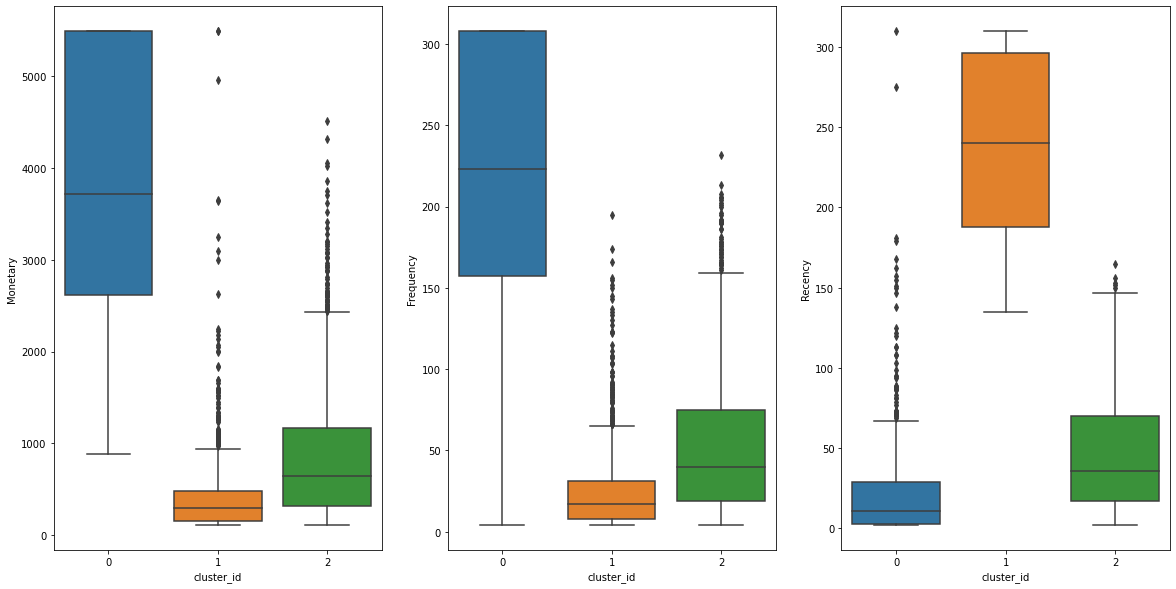

In [49]:
# construct boxplot with different labels
plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
sns.boxplot( x="cluster_id", y="Monetary", data=customer_model_final)

plt.subplot(1,3,2)
sns.boxplot( x="cluster_id", y="Frequency", data=customer_model_final)

plt.subplot(1,3,3)
sns.boxplot( x="cluster_id", y="Recency", data=customer_model_final)
plt.show()

- Customers with cluster_id 0 (blue boxes) are high-value because they spend a lot, purchase very frequently and are recent buyers.

- Customers with cluster_id 1 (orange boxes) are low-value because they spend the least, purchase the least frequently and have not bought anything since a long time ago.

- These observations leave customers with cluster_id 2 (green boxes) to be high-potential customers. They do not buy too much, but they pruchase regularly and are recent buyers. 

To transform high-potential customers to high-value customers, we will send them marketing campaigns. Their identities can be traced using their customer ID.

In [50]:
# find high-potential customers
high_potential = np.array(customer_model_final[customer_model_final['cluster_id'] == 2]['CustomerID'])
high_potential

array([12820, 12822, 12823, ..., 18278, 18282, 18287])

## **Conclusion**

This assignment provides eight different clustering models for customer segmentation and one clustering ensemble at the end. The final clustering result is pleasing as it satisfies the business objective - dividing customers into 3 groups with clear business interpretation.

## **Limitation**

- The outlier effect is very strong. Even our final ensemble model is supposed to be robust, we still see many outliers in the boxplot graph. 

- Noy many tuning on Agglomerative Hierarchical Clustering and Gaussian Mixture. It would be better to try non-default hyperparameters.

- The models with Z-score normalisation generally perform worse than those with MinMax normalisation in this assignment. This may be due to the use of wrong range of hyperparameters for Z-score normalisation.

## **Reference**

Maklin, C., 2022. DBSCAN Python Example: The Optimal Value For Epsilon (EPS). [online] Medium. Available at: <https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc> [Accessed 4 March 2022].

Nabriya, P., 2022. A routine to choose eps and minPts for DBSCAN. [online] Cross Validated. Available at: <https://stats.stackexchange.com/questions/88872/a-routine-to-choose-eps-and-minpts-for-dbscan> [Accessed 4 March 2022].

scikit-learn. 2022. sklearn.metrics.davies_bouldin_score. [online] Available at: <https://scikit-learn.org/stable/modules/generated/sklearn.metrics.davies_bouldin_score.html> [Accessed 4 March 2022].

Bhardwaj, A., 2022. Silhouette Coefficient : Validating clustering techniques. [online] Medium. Available at: <https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c> [Accessed 4 March 2022].